In [1]:
#Author: James Negus

import math
import os
import glob
import csv
import shutil

import warnings
warnings.simplefilter('error', RuntimeWarning)

from math import log10, floor

import numpy as np
import numpy.ma as ma
from numpy import arange,array,ones
from numpy import exp, linspace, random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy.modeling import models, fitting
import astropy.io.ascii as a

# from uncertainties import unumpy
# from uncertainties import ufloat

import pylab as plb

from scipy.optimize import curve_fit
from scipy.optimize import leastsq as lmfitter
from scipy import signal
from scipy import asarray as ar,exp
from scipy.stats import chisquare
from scipy.stats import stats
from scipy.integrate import quad
from scipy.stats import linregress

import scipy.io
import scipy.integrate as integrate

from IPython.display import display, Math

from itertools import chain

#import sherpa.ui as ui
import pandas as pd
from sklearn.linear_model import LinearRegression

# import marvin
# #from marvin.tools import Maps
# from marvin.utils.general.images import showImage
# from marvin.tools.cube import Cube
# from marvin import config

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

%matplotlib inline

#Emission Lines (Vacuum)

OVI = 1033.82 
Ly_Alpha = 1215.24  
NV = 1240.81  
OI = 1305.53  
CII = 1335.31  
Si_IV = 1397.61  
Si_IV_O_IV = 1399.8  
CIV = 1549.48  
He_II = 1640.4
OIII = 1665.85 
Al_III = 1857.4 
CIII = 1908.734 
CII = 2326.0 
Ne_IV = 2439.5 
Mg_II = 2799.117 
NeV_3346 = 3346.79 #*
Ne_VI = 3426.85 
FeVII_3586 = 3586 #*
OII_1 = 3727.092 ###
OII_2 = 3729.875  
FeVII_3760 = 3760 #*
He_I = 3889.0 
SII = 4072.3 
H = 4102.89 
H = 4341.68  
OIII_1 = 4364.436  
H_Beta = 4862.68  
OIII_2 = 4932.603  
OIII_3 = 4960.295  
OIII_4 = 5008.240  
FeVII_6086 = 6086 #*
OI_1 = 6302.046  
OI_2 = 6365.536  ###
FeX_6374 = 6374 #* Very hard to detect because it is so weak. 
NI = 6529.03  
NII_1 = 6549.86 
H_Alpha = 6564.614  
NII_2 = 6585.27  
SII = 6718.29  
SII = 6732.67  

#Absorption Lines

K = 3934.777  
H = 3969.588 
G = 4305.61  
Mg = 5176.7  
Na = 5895.6  
CaII_1 = 8500.36  
CaII_2 = 8544.44  
CaII_3 = 8664.52  

#Sky Lines

Sky_1 = 5578.5 
Sky_2 = 5894.6  
Sky_3 = 6301.7  
Sky_4 = 7246.0 

c = 299792 #speed of light km/s 
H_0 = 70 #Hubble constant km/mpc/s

In [6]:
counter = 0
for plate in chain(range(8311, 8312, 1)):

# for plate in chain(range(7443, 7444, 1), range(7495, 7496, 1), range(7815,7816, 1), range(7957,7994, 1), range(8077,8098, 1), 
#                    range(8131,8159, 1), range(8239, 8275, 1), range(8309, 8487, 1),
#                    range(8547, 8658, 1), range(8711, 8729, 1), range(8931, 9096, 1),
#                    range(9181, 9197, 1), range(9485, 9515, 1), range(9862, 9895, 1), 
#                    range(10001, 10002, 1), range(10141, 10148, 1), range(10213, 10222, 1), range(10492, 10520, 1)):
    #                      range(9673, 9679, 1),    
    
 #   
    for ifu in chain(range(3704,3705, 1)):
        
#     for ifu in chain(range(1901,1903, 1), range(3701, 3705, 1), 
#                      range(6101, 6105, 1), range(9101, 9103, 1), range(12701, 12706, 1)):

        os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
              'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/VOR10-MILESHC-MILESHC/'
              +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
              +'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz output/')
        os.system('gunzip output/manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz')


        def emission(emline, bounds, emline_name):
            for fitsName in glob.glob('output/*.fits'):
              
                hdulist = fits.open(fitsName) 
                wavelength_import = hdulist[4].data #Importing Wavelength Values
                flux_import = hdulist[1].data
                ivar = hdulist[2].data
                
                drpall = fits.open('drpall-v2_5_3.fits') #Opening drpall file
                tbdata = drpall[1].data #Accessing drpall data
                ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
                iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
                plateifu1 = tbdata['plateifu'][ind][0]
                sersic_mass = tbdata['nsa_sersic_mass'][ind][0] #Stellar mass from K-correction fit in h-2 solar masses to sersic magnitudes. 
                
                dapall = fits.open('dapall-v2_5_3-2.3.0.fits') #Opening dapall file
                tbdata_1 = dapall[1].data #Accessing dapall data
                ind_1 = np.where(tbdata_1['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
                velocity_dispersion = tbdata_1['STELLAR_SIGMA_1RE'][ind][0] 
                smbh_mass = (3.1*(velocity_dispersion/200)**4)*(10**8)
                distance = ((tbdata['z'][ind][0])*c)/H_0
                sfr = tbdata_1['SFR_1RE'][ind][0] 
                
                wavelength = wavelength_import/(tbdata['z'][ind][0] + 1)
                
                if emline == FeVII_3586 and tbdata['z'][ind][0] < 0.0136642:
                    hdulist.close()
                    drpall.close()  
                    break
                
                if emline == NeV_3346 and tbdata['z'][ind][0] < 0.0861153:
                    hdulist.close()
                    drpall.close()  
                    break
                
                index1,index2,index3 = flux_import.shape
                cp = int(index2/2)
                cp_down = cp-3
                cp_up = cp+3
                pd = int(index3/2)
                p_down = pd-3
                p_up = pd+3
                
                #Nuclear region flux
                flux_nuclear_dimensions = flux_import[:,cp_down:cp_up,p_down:p_up]
                flux_nuclear_dimensions_ivar = ivar[:,cp_down:cp_up,p_down:p_up]
                flux_nuclear_sum = flux_nuclear_dimensions.sum(axis = (0))
                flux_nuclear_sum_ivar = flux_nuclear_dimensions_ivar.sum(axis = (0))
                flux = flux_nuclear_dimensions.sum(axis = (1, 2))
                flux_ivar = flux_nuclear_dimensions_ivar.sum(axis = (1, 2))
                
                #Galaxy flux
                flux_galaxy = flux_import.sum(axis = (0))
                flux_galaxy_1d = flux_import.sum(axis = (1,2))
                
                #Defining neighboring wavelengths
                wavelength_absolute = np.abs(wavelength - emline) 
                wavelength_min = np.argmin(wavelength_absolute)
                
                #FeVII_3076 Neighboring Lines
                wavelength_oii1 = np.abs(wavelength - OII_1) 
                wavelength_min_oii1 = np.argmin(wavelength_oii1)
                wavelength_oii2 = np.abs(wavelength - OII_2) 
                wavelength_min_oii2 = np.argmin(wavelength_oii2)
                wavelength_hei = np.abs(wavelength - He_I) 
                wavelength_min_hei = np.argmin(wavelength_hei)
                
                #FeVII_6086 Neighboring Lines
                wavelength_na = np.abs(wavelength - Na) 
                wavelength_min_na = np.argmin(wavelength_na) 
            
                #FeX_6374 Neighboring Lines
                wavelength_oi1 = np.abs(wavelength - OI_1) 
                wavelength_min_oi1 = np.argmin(wavelength_oi1)
                wavelength_oi2 = np.abs(wavelength - OI_2) 
                wavelength_min_oi2 = np.argmin(wavelength_oi2)
                wavelength_ni = np.abs(wavelength - NI) 
                wavelength_min_ni = np.argmin(wavelength_ni)
                wavelength_nii1 = np.abs(wavelength - NII_1) 
                wavelength_min_nii1 = np.argmin(wavelength_nii1)
                wavelength_nii2 = np.abs(wavelength - NII_2) 
                wavelength_min_nii2 = np.argmin(wavelength_nii2)
                wavelength_halpha = np.abs(wavelength - H_Alpha) 
                wavelength_min_halpha = np.argmin(wavelength_halpha)
                
                #NeV_3346 Neighboring Lines
                wavelength_nevi = np.abs(wavelength - Ne_VI) 
                wavelength_min_nevi = np.argmin(wavelength_nevi)
                
                #H-Alpha Neighboring Lines
                wavelength_oiii3 = np.abs(wavelength - OIII_3) 
                wavelength_min_oiii3 = np.argmin(wavelength_oiii3)
                
                #Determining observed (for vmeasured value)
            #         lambda_obs = (tbdata['z'][ind][0] + 1)*emline
            #         wavelength_absolute = np.abs(wavelength - lambda_obs) 
            #         wavelength_min = np.argmin(wavelength_absolute)

                #Spectrum parameters
                x_0, x_1 = wavelength_min - bounds, wavelength_min + bounds #Setting lower bound for linear fit
                if x_0 < 0:
                    x_0 = 0
                #Setting upper bound for linear fit
                z_1_2 = x_0 - 10*bounds
                if z_1_2 < 0:
                    z_1_2 = 0
                x_1_2 = x_1 + 10*bounds

                wavelength_bounds_total = wavelength[z_1_2:x_1_2] 
                wavelength_total = np.abs(wavelength_bounds_total - emline) 
                wavelength_min_total = np.argmin(wavelength_total)
                
                wavelength_mask_total = np.ma.masked_array(wavelength_bounds_total,
                                                     (wavelength_bounds_total != wavelength_bounds_total[0])& 
                                                     (wavelength_bounds_total != wavelength_bounds_total[-1])) 
                wavelength_compressed_total = wavelength_mask_total.compressed() 
                
                flux_bounds_total = flux[z_1_2:x_1_2] 
                flux_bounds_total_ivar = flux_ivar[z_1_2:x_1_2] 
    
                flux_mask_total = np.ma.masked_array(flux_bounds_total, (flux_bounds_total != flux_bounds_total[0]) 
                                           & (flux_bounds_total != flux_bounds_total[-1]))
                flux_compressed_total = flux_mask_total.compressed() 
                
                if flux_compressed_total.shape[0] == 3:
                    print ('duplicate')
                    flux_1,flux_2 = flux_compressed_total[0],flux_compressed_total[2]
                    flux_compressed_total = [flux_1, flux_2]
                
                if flux_compressed_total[0] != 0:
        
                    polyfit_total = np.polyfit(wavelength_compressed_total,flux_compressed_total, 1) #Fitting the line to the data
                    fit_total = np.poly1d(polyfit_total)
                    flux_linear_total = fit_total[1]*wavelength_bounds_total + fit_total[0] #Determining linear fit parameters
                    flux_correction_total = flux_bounds_total - flux_linear_total #Correcting for continuum
                    
                    for i in flux_correction_total:
                        if i < 0:
                            negative = np.argmin(flux_correction_total)
                            flux_correction_total = flux_correction_total + abs(flux_correction_total[negative])
                            break
                            
                    q_0, q_1 = wavelength_min_total - bounds, wavelength_min_total + bounds
                    if q_0 < 0:
                        q_0 = 0
                    wavelength_bounds = wavelength_bounds_total[q_0:q_1]
                    flux_bounds = flux_correction_total[q_0:q_1]
                    flux_bounds_error = np.sqrt(1/flux_bounds_total_ivar[q_0:q_1])

                    wavelength_bounds_min = np.abs(wavelength_bounds - emline) 
                    wavelength_bounds_min_total = np.argmin(wavelength_bounds_min)
                
                    wavelength_mask = np.ma.masked_array(wavelength_bounds,
                                                     (wavelength_bounds != wavelength_bounds[0])& 
                                                     (wavelength_bounds != wavelength_bounds[-1])) 
                    wavelength_compressed = wavelength_mask.compressed() 
                
                    flux_mask = np.ma.masked_array(flux_bounds, (flux_bounds != flux_bounds[0]) 
                                           & (flux_bounds != flux_bounds[-1]))
                    flux_compressed = flux_mask.compressed() 
                    
                    if flux_compressed.shape[0] == 3:
                        print ('duplicate')
                        flux_compressed = [flux_1, flux_2]
                    
                    if flux_compressed[0] != 0:
                    
                        polyfit = np.polyfit(wavelength_compressed,flux_compressed, 1) #Fitting the line to the data
                        fit = np.poly1d(polyfit)
                        flux_linear = fit[1]*wavelength_bounds + fit[0] #Determining linear fit parameters
                        avg_flux = np.average(flux_linear)

                    x_1_9 = x_1 + 4*bounds
                    flux_sigma_bounds_1 = flux[x_1 + 5: x_1_9 + 5]
                    f_std = np.std(flux_sigma_bounds_1)
                    flux_sigma = 5*(f_std)
                    flux_sigma_1 = 1*(f_std)

                    if len(fitsName) == 57:
                        print ('\n' + iau + ' ('+ fitsName[13:22] + ') ' + emline_name + ' ' +
                        '\n' + 'Five Sigma (ergs/cm^2/A/spaxel) = ' + str(flux_sigma))
                    if len(fitsName) == 58:
                        print ('\n' + iau + ' (' + fitsName[13:23] + ') ' + emline_name + ' ' +
                        '\n' + 'Five Sigma (ergs/cm^2/A/spaxel) = ' + str(flux_sigma))
                    if len(fitsName) == 59:
                        print ('\n' + iau + ' (' + fitsName[13:24] + ') ' + emline_name + ' ' +
                        '\n' + 'Five Sigma (ergs/cm^2/A/spaxel) = ' + str(flux_sigma))
                    
                    def gaus(x,amp,mu,sigma, m, c):
                        return amp*np.exp(-(x-mu)**2/(2*sigma**2)) + m*x + c #Defining Gaussian function

                    def double_gaussian(x,amp1,mu1,sigma1,m1,c1,amp2,mu2,sigma2,m2,c2):
                        return gaus(x,amp1,mu1,sigma1,m1,c1) + gaus(x,amp2,mu2,sigma2,m2,c2)
                    
                    wavelength_emission = np.argmax(flux_bounds)
                    amp_ems = flux_bounds[wavelength_emission]
                    wavelength_absorption = np.argmin(flux_bounds)
                    amp_abs = flux_bounds[wavelength_absorption]
                    amp_abs_1 = -(avg_flux - amp_abs)
                    sigma_abs_1 = avg_flux - flux_sigma_1
                    sigma_abs_5 = avg_flux - flux_sigma
                    sigma_ems = avg_flux + flux_sigma
                    
                    o1_wavelength_total = np.abs(wavelength_bounds - OI_2) 
                    o1_wavelength_min_total = np.argmin(o1_wavelength_total)
                    amp_o1 = flux_bounds[o1_wavelength_min_total]
                    mu_o1 = wavelength_bounds[o1_wavelength_min_total]
                    sigma_guess_o1 = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu_o1)**2)/np.sum(flux_bounds))
                    
                    mu_abs = wavelength_bounds[wavelength_absorption]
                    mu_ems = wavelength_bounds[wavelength_emission]
                    mu = np.sum(wavelength_bounds*flux_bounds)/np.sum(flux_bounds)
                    
                    sigma_guess = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu)**2)/np.sum(flux_bounds))
                    amp = flux_bounds[wavelength_bounds_min_total]
                    
                    if amp_abs < sigma_abs_5:
                        hdulist.close()
                        drpall.close() 
                        print ('5 Sigma Absorption Line Error')
                        break

                    if amp_abs < sigma_abs_1 and amp_ems < sigma_ems:
                    
                        try:
                            popt, pcov = curve_fit(gaus,wavelength_bounds, flux_bounds,  
                                       p0=[amp_abs_1, mu_abs, sigma_guess, fit[1], 
                                           fit[0]])
                        except RuntimeError:
                            hdulist.close()
                            drpall.close() 
                            print ('RuntimeError')
                            break

                        print (emline_name + ' Absorption Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]))
                        
                        if popt[0] < 0:
                            hdulist.close()
                            drpall.close() 
                            print ('Absorption Line Error')
                            break
                        
                        else:
                            try:
                                popt, pcov = curve_fit(gaus,wavelength_bounds, flux_bounds,  
                                           p0=[amp_ems, mu, sigma_guess, fit[1], 
                                               fit[0]])
                            except RuntimeError:
                                hdulist.close()
                                drpall.close() 
                                print ('RuntimeError')
                                break

                            try:
                                perr = np.sqrt(np.diag(pcov))
                            except RuntimeWarning:
                                print ('RuntimeWarning')
                                perr = 0
                            residuals = flux_bounds - gaus(wavelength_bounds, *popt) #Determines the uncertainty in ydata

                            chi_squared =  np.sum(((residuals)** 2)/(gaus(wavelength_bounds, *popt)))
                            reduced_chi_squared = chi_squared / (len(popt) - 1)

                            print ('Chi Squared test = ' +  str(chi_squared) + '\n' + 'Reduced Chi Squared = ' 
                                   + str(reduced_chi_squared))
                            
                            print (emline_name + ' Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]))
                        
                    else:
                        try:
                            popt, pcov = curve_fit(gaus,wavelength_bounds, flux_bounds,  
                                       p0=[amp_ems, mu, sigma_guess, fit[1], 
                                           fit[0]])
                        except RuntimeError:
                            hdulist.close()
                            drpall.close() 
                            print ('RuntimeError')
                            break
                            
                        try:
                            perr = np.sqrt(np.diag(pcov))
                        except RuntimeWarning:
                            print ('RuntimeWarning')
                            perr = 0
                        residuals = flux_bounds - gaus(wavelength_bounds, *popt) #Determines the uncertainty in ydata
                      
                        chi_squared =  np.sum(((residuals)** 2)/(gaus(wavelength_bounds, *popt)))
                        reduced_chi_squared = chi_squared / (len(popt) - 1)
       
                        print ('Single Gaussian Chi Squared = ' +  str(chi_squared) + '\n' + 'Single Gaussian Reduced Chi Squared = ' 
                               + str(reduced_chi_squared))
                        
                        print (emline_name + ' Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]))
                        print (*popt)
                        
                    if emline == FeX_6374:    
                        try:
                            popt_dg, pcov_dg = curve_fit(double_gaussian,wavelength_bounds, flux_bounds,  
                                           p0=[amp,mu,sigma_guess,fit[1],fit[0],amp_o1,mu_o1,sigma_guess_o1,fit[1],fit[0]]) 
                        except RuntimeError:
                            hdulist.close()
                            drpall.close() 
                            print ('RuntimeError')
                            break
                       
                        try:
                            perr_dg = np.sqrt(np.diag(pcov_dg))
                        except RuntimeWarning:
                            print ('RuntimeWarning')
                            perr_dg = 0
                        residuals_dg = flux_bounds - double_gaussian(wavelength_bounds, *popt_dg) #Determines the uncertainty in ydata
                        
                        chi_squared_dg =  np.sum(((residuals_dg)** 2)/(double_gaussian(wavelength_bounds, *popt_dg)))
                        reduced_chi_squared_dg = chi_squared_dg / (len(popt_dg) - 1)
       
                        print ('Double Gaussian Chi Squared = ' +  str(chi_squared_dg) + '\n' + 'Double Gaussian Reduced Chi Squared = ' 
                               + str(reduced_chi_squared_dg))
                        
                        print (emline_name + ' OI Flux (ergs/cm^2/A/spaxel) = ' + str(popt_dg[5]) + '\n'
                               + emline_name + ' FeX Flux (ergs/cm^2/A/spaxel) = ' + str(popt_dg[0]))
                        
                        velocity_meas_dg = c*((popt_dg[1] - emline)/emline)
                        velocity_sys_dg = c*tbdata['z'][ind][0]
                        velocity_off_dg = velocity_sys_dg - velocity_meas_dg
                        sigma_dg = c*(abs(popt_dg[2])/emline)
                        fwhm_dg = sigma_dg*2.355
                        ip = 262.1
                        
                        #if sigma_dg > 0 and sigma_dg < 450 and popt_dg[0] > flux_sigma and mu-15 < popt_dg[1] < mu+15 and popt_dg[0] > 3*perr_dg[0]:
                        
                        newpath = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline_name + '%s/'%iau
                        if not os.path.exists(newpath):
                            os.makedirs(newpath)
                        f = open(newpath + "dg_data.csv","w+")
                        f.write('SDSS Name' + ',' + 'Redshift' + ',' + 'Distance (Mpc)' + ',' + '5 Sigma Threshold (ergs/cm^2/A/spaxel)'
                                 + ',' + 'Gaussian Amplitude (ergs/cm^2/A/spaxel)' + ',' 
                                + 'Gaussian Amplitude Error (ergs/cm^2/A/spaxel)'+ ',' 
                                + 'Gaussian Centroid (A)' + ',' + 'Gaussian Centroid Error (A)' + ',' 
                                + 'Gaussian Sigma (A)' + ',' 
                                + 'Gaussian Sigma Error (A)'+ ','+ 'Sigma (km/s)' + ',' + 'FWHM (km/s)' + ',' + 'Measured Velocity (km/s)' 
                                + ',' + 'SMBH Mass(Solar Masses)' + ',' + 'Sersic Mass (Solar Masses)'+  ',' + 'Velocity Dispersion (km/s)' + ','
                                 + 'SFR (h-2 Msun/yr)' + ',' + 'Chi Squared' + ',' + 'Reduced Chi Squared' +  ',' + 'Ionization Energy (eV)'+
                                '\n' + str(iau) + ',' + str(tbdata['z'][ind][0]) + ',' + str(distance) + ',' + str(flux_sigma) + ',' 
                                + str(popt_dg[0])+ ',' + str(perr_dg[0]) 
                                + ','  + str(popt_dg[1]) + ',' + str(perr_dg[1]) +  ','  + str(popt_dg[2]) + ',' + str(perr_dg[2]) + ',' 
                                + str(sigma_dg) + ','  + str(fwhm_dg) + ',' + str(velocity_meas_dg)+ ',' + str(smbh_mass) + ',' + str(sersic_mass) 
                                + ','  + str(velocity_dispersion) + ',' + str(sfr) + ',' + str(chi_squared_dg) + ',' + str(reduced_chi_squared_dg) 
                                + ',' + str(ip))
                        f.close()

                        fig = plt.figure(figsize=(15,10))
                        ax1 = plt.axes()  
                        ax2 = plt.axes([0.18, 0.7, 0.15, 0.15])
                        ax1.plot(wavelength_bounds_total, flux_correction_total, 'b', label = 'Data')

                        ax2.plot(wavelength_bounds, residuals, 'k')
                        ax2.set_title('Residuals')
                        ax2.set_ylabel('Flux')
                        ax2.set_xlabel(r'Wavelength ($\AA$)')

                        if len(fitsName) == 57:
                            ax1.set_title(iau + ' ('+ fitsName[13:22] + ')')
                        if len(fitsName) == 58:
                            ax1.set_title(iau + ' ('+ fitsName[13:23] + ')')
                        if len(fitsName) == 59:
                            ax1.set_title(iau + ' ('+ fitsName[13:24] + ')')

                        ax1.set_ylabel('Flux', fontsize = 15)
                        ax1.set_xlabel(r'Wavelength ($\AA$)', fontsize = 15)
                        r = wavelength_bounds_total.shape
                        ax1.set_xlim(wavelength_bounds_total[1],wavelength_bounds_total[r[0] - 1])

                        marker = np.argmin(flux_correction_total)
                        marker_min = np.argmax(flux_correction_total)
                        marker_threshold = -(0.035*flux_correction_total[marker_min])

                        ax1.text(wavelength[x_1 + 15], marker_threshold, 'Neighboring Continuum', fontsize=9)


                        ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                        ax1.text(wavelength[wavelength_min-3], marker_threshold, 'FeX', fontsize=9)
                        ax1.plot(wavelength[wavelength_min_oi2],flux_correction_total[marker], marker='|', color = 'purple', linestyle='None')
                        ax1.text(wavelength[wavelength_min_oi2-2], marker_threshold, 'OI', fontsize=9)
                        ax1.plot(wavelength[wavelength_min_oi1],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                        ax1.text(wavelength[wavelength_min_oi1-2], marker_threshold, 'OI', fontsize=9)
                        ax1.plot(wavelength[wavelength_min_ni],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                        ax1.text(wavelength[wavelength_min_ni-2], marker_threshold, 'NI', fontsize=9)
                        ax1.plot(wavelength[wavelength_min_nii1],flux_correction_total[marker], marker='|', color = 'magenta', linestyle='None')
                        ax1.text(wavelength[wavelength_min_nii1-3], marker_threshold, 'NII', fontsize=9)
                        ax1.plot(wavelength[wavelength_min_nii2],flux_correction_total[marker], marker='|', color = 'cyan', linestyle='None')
                        ax1.text(wavelength[wavelength_min_nii2-3], marker_threshold, 'NII', fontsize=9)
                        ax1.plot(wavelength[wavelength_min_halpha],flux_correction_total[marker], marker='|', color = 'pink', linestyle='None')
                        ax1.text(wavelength[wavelength_min_halpha-6], marker_threshold, 'Halpha', fontsize=9)


                        ax1.axvline(x = wavelength[x_0], linestyle = '--', color = 'r')
                        ax1.axvline(x = wavelength[x_1], linestyle = '--', color = 'r')
                        ax1.axvline(x = wavelength[x_1 + 5], linestyle = '-', color = 'k')
                        ax1.axvline(x = wavelength[x_1_9 + 5], linestyle = '-', color = 'k')

                        p_i = wavelength_bounds.shape[0]
                        wavelength_range = np.arange(wavelength_bounds[0],wavelength_bounds[p_i-1], 0.25)

                        ax1.plot(wavelength_bounds,double_gaussian(wavelength_bounds, *popt_dg), 'r-', label = 'Gaussian')

                        ax1.legend(loc = 1)

                        fig.savefig(newpath + iau + '_' + emline_name + '_dg.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0.1)
                        #plt.show()
                        plt.close()

                        #Continuum Flux Maps
                        f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                        cax1 = ax1.imshow(flux_galaxy, cmap='gist_heat', origin = 'lower', norm=LogNorm())
                        ax1.set_title(iau + ' Continuum Galaxy Flux Map')
                        ax1.set_xlabel('Spaxels')
                        ax1.set_ylabel('Spaxels')
                        f.colorbar(cax1, ax = ax1, label = 'Flux')
                        vmin, vmax = cax1.get_clim()
                        cax2 = ax2.imshow(flux_nuclear_sum, cmap='gist_heat', origin = 'lower', norm=LogNorm())
                        ax2.set_title(iau + ' Continuum Nuclear Flux Map')
                        ax2.set_xlabel('Spaxels')
                        ax2.set_ylabel('Spaxels')
                        f.colorbar(cax2, ax = ax2, label = 'Flux')
                        f.savefig(newpath +  iau + '_' + 'continuum_flux_maps_dg.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                        #plt.show()
                        plt.close()

                        #Emission Line Flux Maps
                        f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                        cax1 = ax1.imshow(flux_import[x_0:x_1, :, :].sum(axis = 0), cmap='gist_heat', origin = 'lower', norm=LogNorm(), vmax = vmax)
                        ax1.set_title(iau  + ' ' + emline_name + ' ' + ' Galaxy Flux Map')
                        ax1.set_xlabel('Spaxels')
                        ax1.set_ylabel('Spaxels')
                        f.colorbar(cax1, ax = ax1, label = 'Flux')
                        cax2 = ax2.imshow(flux_nuclear_dimensions[x_0:x_1, :, :].sum(axis = (0)), cmap='gist_heat', origin = 'lower', norm=LogNorm(), vmax = vmax)
                        ax2.set_title(iau  + ' ' + emline_name + ' ' + ' Nuclear Flux Map')
                        ax2.set_xlabel('Spaxels')
                        ax2.set_ylabel('Spaxels')
                        f.colorbar(cax2, ax = ax2, label = 'Flux')
                        f.savefig(newpath +  iau + '_' + 'emission_line_flux_maps_dg.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                        #plt.show()
                        plt.close() 

                    
                    velocity_meas = c*((popt[1] - emline)/emline)
                    velocity_sys = c*tbdata['z'][ind][0]
                    velocity_off = velocity_sys - velocity_meas
                    sigma = c*(abs(popt[2])/emline)
                    fwhm = sigma*2.355

            
                    if emline == FeVII_3586 or FeVII_3760 or FeVII_6086:
                        ip = 124.98  
                    if emline == FeX_6374:
                        ip = 262.1
                    if emline == NeV_3346:
                        ip = 126.21

                    # sigma_threshold = ((2000/2.355)/c)*(wavelength[wavelength_min])

                    if sigma > 0 and sigma < 450 and popt[0] > flux_sigma and mu-15 < popt[1] < mu+15 and popt[0] > 3*perr[0]:
                        
                        newpath = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline_name + '%s/'%iau
                        if not os.path.exists(newpath):
                            os.makedirs(newpath)
                        f = open(newpath + "data.csv","w+")
                        f.write('SDSS Name' + ',' + 'Redshift' + ',' + 'Distance (Mpc)' + ',' + '5 Sigma Threshold (ergs/cm^2/A/spaxel)'
                                 + ',' + 'Gaussian Amplitude (ergs/cm^2/A/spaxel)' + ',' 
                                + 'Gaussian Amplitude Error (ergs/cm^2/A/spaxel)'+ ',' 
                                + 'Gaussian Centroid (A)' + ',' + 'Gaussian Centroid Error (A)' + ',' 
                                + 'Gaussian Sigma (A)' + ',' 
                                + 'Gaussian Sigma Error (A)'+ ','+ 'Sigma (km/s)' + ',' + 'FWHM (km/s)' + ',' + 'Measured Velocity (km/s)' 
                                + ',' + 'SMBH Mass(Solar Masses)' + ',' + 'Sersic Mass (Solar Masses)'+  ',' + 'Velocity Dispersion (km/s)' + ','
                                 + 'SFR (h-2 Msun/yr)' + ',' + 'Chi Squared' + ',' + 'Reduced Chi Squared' +  ',' + 'Ionization Energy (eV)'+
                                '\n' + str(iau) + ',' + str(tbdata['z'][ind][0]) + ',' + str(distance) + ',' + str(flux_sigma) + ',' 
                                + str(popt[0])+ ',' + str(perr[0]) 
                                + ','  + str(popt[1]) + ',' + str(perr[1]) +  ','  + str(popt[2]) + ',' + str(perr[2]) + ',' 
                                + str(sigma) + ','  + str(fwhm) + ',' + str(velocity_meas)+ ',' + str(smbh_mass) + ',' + str(sersic_mass) 
                                + ','  + str(velocity_dispersion) + ',' + str(sfr) + ',' + str(chi_squared) + ',' + str(reduced_chi_squared) 
                                + ',' + str(ip))
                        f.close()

                        fig = plt.figure(figsize=(15,10))
                        ax1 = plt.axes()  
                        ax2 = plt.axes([0.18, 0.7, 0.15, 0.15])
                        ax1.plot(wavelength_bounds_total, flux_correction_total, 'b', label = 'Data')

                        ax2.plot(wavelength_bounds, residuals, 'k')
                        ax2.set_title('Residuals')
                        ax2.set_ylabel('Flux')
                        ax2.set_xlabel(r'Wavelength ($\AA$)')

                        if len(fitsName) == 57:
                            ax1.set_title(iau + ' ('+ fitsName[13:22] + ')')
                        if len(fitsName) == 58:
                            ax1.set_title(iau + ' ('+ fitsName[13:23] + ')')
                        if len(fitsName) == 59:
                            ax1.set_title(iau + ' ('+ fitsName[13:24] + ')')

                        ax1.set_ylabel('Flux', fontsize = 15)
                        ax1.set_xlabel(r'Wavelength ($\AA$)', fontsize = 15)
                        r = wavelength_bounds_total.shape
                        ax1.set_xlim(wavelength_bounds_total[1],wavelength_bounds_total[r[0] - 1])

                        marker = np.argmin(flux_correction_total)
                        marker_min = np.argmax(flux_correction_total)
                        marker_threshold = -(0.035*flux_correction_total[marker_min])

                        ax1.text(wavelength[x_1 + 15], marker_threshold, 'Neighboring Continuum', fontsize=9)

                        if emline == FeVII_3586:
                            ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                            ax1.text(wavelength[wavelength_min-4], marker_threshold, 'FeVII', fontsize=9)

                        if emline == FeVII_3760:
                            ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                            ax1.text(wavelength[wavelength_min-4], marker_threshold, 'FeVII', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_oii1],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                            ax1.text(wavelength[wavelength_min_oii1-1], marker_threshold, 'OII', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_oii2],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                            #ax1.text(wavelength[wavelength_min_oii2-3], marker_threshold, fontsize=9)
                            ax1.plot(wavelength[wavelength_min_hei],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                            ax1.text(wavelength[wavelength_min_hei-3], marker_threshold, 'OII', fontsize=9)


                        if emline == FeVII_6086:
                            ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                            ax1.text(wavelength[wavelength_min-4], marker_threshold, 'FeVII', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_na],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                            ax1.text(wavelength[wavelength_min_na-2], marker_threshold, 'Na', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_oi1],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                            ax1.text(wavelength[wavelength_min_oi1-2], marker_threshold, 'OI', fontsize=9)

                        if emline == FeX_6374:
                            ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                            ax1.text(wavelength[wavelength_min-3], marker_threshold, 'FeX', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_oi2],flux_correction_total[marker], marker='|', color = 'purple', linestyle='None')
                            ax1.text(wavelength[wavelength_min_oi2-2], marker_threshold, 'OI', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_oi1],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                            ax1.text(wavelength[wavelength_min_oi1-2], marker_threshold, 'OI', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_ni],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                            ax1.text(wavelength[wavelength_min_ni-2], marker_threshold, 'NI', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_nii1],flux_correction_total[marker], marker='|', color = 'magenta', linestyle='None')
                            ax1.text(wavelength[wavelength_min_nii1-3], marker_threshold, 'NII', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_nii2],flux_correction_total[marker], marker='|', color = 'cyan', linestyle='None')
                            ax1.text(wavelength[wavelength_min_nii2-3], marker_threshold, 'NII', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_halpha],flux_correction_total[marker], marker='|', color = 'pink', linestyle='None')
                            ax1.text(wavelength[wavelength_min_halpha-6], marker_threshold, 'Halpha', fontsize=9)

    #                             if emline == OIII_4:
    #                                 plt.plot(wavelength[wavelength_min_oiii3],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
    #                                 plt.text(wavelength[wavelength_min_oiii3-4], marker_threshold, 'OIII', fontsize=9)

                        if emline == NeV_3346:
                            ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                            ax1.text(wavelength[wavelength_min-3], marker_threshold, 'NeV', fontsize=9)
                            ax1.plot(wavelength[wavelength_min_nevi],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                            ax1.text(wavelength[wavelength_min_nevi-4], marker_threshold, 'Ne_VI', fontsize=9)

                        ax1.axvline(x = wavelength[x_0], linestyle = '--', color = 'r')
                        ax1.axvline(x = wavelength[x_1], linestyle = '--', color = 'r')
                        ax1.axvline(x = wavelength[x_1 + 5], linestyle = '-', color = 'k')
                        ax1.axvline(x = wavelength[x_1_9 + 5], linestyle = '-', color = 'k')

                        p_i = wavelength_bounds.shape[0]
                        wavelength_range = np.arange(wavelength_bounds[0],wavelength_bounds[p_i-1], 0.25)

                        ax1.plot(wavelength_range,gaus(wavelength_range, *popt), 'r-', label = 'Gaussian')
                        ax1.legend(loc = 1)

                        fig.savefig(newpath + iau + '_' + emline_name + '.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0.1)
                        #plt.show()
                        plt.close()

                        #Continuum Flux Maps
                        f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                        cax1 = ax1.imshow(flux_galaxy, cmap='gist_heat', origin = 'lower', norm=LogNorm())
                        ax1.set_title(iau + ' Continuum Galaxy Flux Map')
                        ax1.set_xlabel('Spaxels')
                        ax1.set_ylabel('Spaxels')
                        f.colorbar(cax1, ax = ax1, label = 'Flux')
                        vmin, vmax = cax1.get_clim()
                        cax2 = ax2.imshow(flux_nuclear_sum, cmap='gist_heat', origin = 'lower', norm=LogNorm())
                        ax2.set_title(iau + ' Continuum Nuclear Flux Map')
                        ax2.set_xlabel('Spaxels')
                        ax2.set_ylabel('Spaxels')
                        f.colorbar(cax2, ax = ax2, label = 'Flux')
                        f.savefig(newpath +  iau + '_' + 'continuum_flux_maps.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                        #plt.show()
                        plt.close()
                        
                        #Emission Line Flux Maps
                        f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                        cax1 = ax1.imshow(flux_import[x_0:x_1, :, :].sum(axis = 0), cmap='gist_heat', origin = 'lower', norm=LogNorm(), vmax = vmax)
                        ax1.set_title(iau  + ' ' + emline_name + ' ' + ' Galaxy Flux Map')
                        ax1.set_xlabel('Spaxels')
                        ax1.set_ylabel('Spaxels')
                        f.colorbar(cax1, ax = ax1, label = 'Flux')
                        cax2 = ax2.imshow(flux_nuclear_dimensions[x_0:x_1, :, :].sum(axis = (0)), cmap='gist_heat', origin = 'lower', norm=LogNorm(), vmax = vmax)
                        ax2.set_title(iau  + ' ' + emline_name + ' ' + ' Nuclear Flux Map')
                        ax2.set_xlabel('Spaxels')
                        ax2.set_ylabel('Spaxels')
                        f.colorbar(cax2, ax = ax2, label = 'Flux')
                        f.savefig(newpath +  iau + '_' + 'emission_line_flux_maps.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                        #plt.show()
                        plt.close() 



                             # get a map
                            #maps = Maps(plateifu=plateifu1)

                            # make a standard 3-plot BPT and retrieve the classifications
                            #masks, fig, axes = maps.get_bpt()

                            # save the plot
                            #fig.savefig(dir + iau + '_' + '3_plot_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

        #                             # make a BPT classification without OI
        #                             masks, fig, axes = maps.get_bpt(use_oi=False)
        #                             # save the plot
        #                             fig.savefig(dir + iau + 'no_OI_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

                hdulist.close()
                drpall.close()               

            return;
            

        # Calling the function
#         emission(emline = FeVII_3760, 
#                  bounds = 15, 
#                  emline_name = 'FeVII_3760A')
#         emission(emline = FeVII_6086, 
#                  bounds = 15, 
#                  emline_name = 'FeVII_6086A')
#         emission(emline = NeV_3346, 
#                  bounds = 15,  
#                  emline_name = 'NeV_3346.79A')
#         emission(emline = FeVII_3586, 
#                  bounds = 15, 
#                  emline_name = 'FeVII_3586A')
        emission(emline = FeX_6374, 
                 bounds = 15, 
                 emline_name = 'FeX_6374A')
#         emission(emline = H_Beta, 
#                 bounds = 15, 
#                 emline_name = 'HBeta_4862.68A')
#         emission(emline = OIII_4, 
#                 bounds = 15, 
#                 emline_name = 'OIII_4_5008.240A')
        
        for fitsName in glob.glob('output/*.fits'):
            counter += 1
            print ('\n' + 'Galaxy Counter: ' + str(counter)) 
            os.remove(fitsName)                    



J133602.84+223801.4 (8311-3704) FeX_6374A 
Five Sigma (ergs/cm^2/A/spaxel) = 6.059409976005554
Single Gaussian Chi Squared = 22.06824
Single Gaussian Reduced Chi Squared = 5.517059803009033
FeX_6374A Flux (ergs/cm^2/A/spaxel) = 1.1336604174077423
1.1336604174077423 6384.9542770847165 1.2473066794024372 0.0901481473689345 -568.9971199098399
Double Gaussian Chi Squared = 2.9532142
Double Gaussian Reduced Chi Squared = 0.3281349076165093
FeX_6374A OI Flux (ergs/cm^2/A/spaxel) = -4.853883004531941
FeX_6374A FeX Flux (ergs/cm^2/A/spaxel) = 5.476643547509199

Galaxy Counter: 1


In [43]:
hdulist = fits.open('manga-8154-6103-LOGCUBE-VOR10-MILESHC-MILESHC.fits') #Opening fits file
# flux = hdulist[1].data.sum(axis = (1,2)) #Importing Flux Values 
#flux_1 = hdulist[1].data #Importing Flux Values 
#wavelength_raw = hdulist[4].data #Importing Wavelength Values
drpall = fits.open('drpall-v2_5_3.fits')
#drpall = fits.open('dapall-v2_5_3-2.3.0.fits') #Opening drpall file
tbdata = drpall[1].data #Accessing drpall data
#ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
ind_1 = np.where(tbdata['nsa_iauname'] == 'J074616.81+204508.8')
manga_id = tbdata['plateifu'][ind_1][0] 
print(manga_id)
#velocity_dispersion = tbdata['STELLAR_SIGMA_1RE'][ind][0] 
#wavelength = wavelength_raw/(tbdata['z'][ind][0] + 1)
c = 299792 #speed of light km/s 
#flux = flux_1.sum(axis = (1,2))

#hdulist.close()
#drpall.close()

# fig = plt.figure(figsize=(15,10))
# ax1 = plt.axes()  # standard axes
# ax2 = plt.axes([0.18, 0.65, 0.2, 0.2])
# ax1.plot(wavelength, flux)
# ax2.plot(wavelength,flux)

# i,o,p = flux.shape
# cp = int(o/2)
# cp_down = cp-3
# cp_up = cp+3
# p = int(p/2)
# p_down = p-3
# p_up = p+3
# print (cp_down, cp_up, p_down, p_up)
# str(round_sig(velocity_meas, 2))
# y = flux[:,cp_down:cp_up,p_down:p_up]
# test2 = y.sum(axis = (1, 2))
# test32 = flux.sum(axis = (1, 2))
# plt.figure(figsize=(20,10))
# plt.plot (wavelength, test32)
# plt.title(iau + ' (z = ' + str(tbdata['z'][ind][0]) + ')')
# plt.xlim(4800,5100)
# plt.ylim(300,2000)
# plt.plot(4960.295,400, marker='|', color = 'purple', label = "OIII [3] = 4960.295A", linestyle='None')
# plt.text(4954.295, 350, 'Na_5895.6$\AA$', fontsize=9)
# plt.plot(5008.240,400, marker='|', color = 'red', label = "OIII [4] = 5008.240A", linestyle='None')
# plt.text(5008, 350, 'test', fontsize=9)
# plt.plot(4862.68,400, marker='|', color = 'black', label = "H_Beta = 4862.68A", linestyle='None')
# plt.legend()
# plt.show()

# plt.xlim(5900,6350)
# plt.ylim(40,75)
# # plt.plot(4960.295,40, marker='|', color = 'purple', label = "OIII [3] = 4960.295A", linestyle='None')
# plt.plot(6302.046,42, marker='|', color = 'red', label = "OI_1 = 6302.046", linestyle='None')
# plt.plot(6086,42, marker='|', color = 'black', label = "Fe_VII_3 = 6086A", linestyle='None')
# plt.legend()
# plt.show()


# # #q = np.where(wavelength = )
# test3 = abs(wavelength - FeVII_3760)
# test_min = np.argmin(test3) 
# # #print(wavelength[test_min], test_min)
# # #print (test3)
# # # print (wavelength[1555], wavelength[1579])
# # # print (wavelength[1580] - wavelength[1554])
# # po = flux[25:54, :, :].sum(axis = 0)
# # #print (po.shape)
# # #flux_galaxy = flux_import.sum(axis = (0))
# # #print (flux.shape)
# test = flux[:, :, :].sum(axis = (0))
# u,a = test_min - 30, test_min + 30
# # #print (u, a)
# test54 = flux[u:a, :, :].sum(axis = (0))
# # # #print (flux.shape)
# # # #print (wavelength.shape)

# # # plt.figure(figsize=(20,10))
# # # plt.plot (test32[u:a])
# # # plt.show()

# #fig = plt.figure()
# f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(20,8))
# cax1 = ax1.imshow(test, cmap='gist_heat', origin = 'lower')
# ax1.set_title('Flux Map')
# ax1.set_xlabel('Spaxels')
# ax1.set_ylabel('Spaxels')
# f.colorbar(cax1, ax = ax1, label = 'Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
# #f.colorbar.set_label('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
# cax2 = ax2.imshow(test54, cmap='gist_heat', origin = 'lower')
# ax2.set_title('Flux Map')
# ax2.set_xlabel('Spaxels')
# ax2.set_ylabel('Spaxels')
# f.colorbar(cax2, ax = ax2, label = 'Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
# #f.savefig('nuclear_flux_map.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

# #Emission Line Flux Maps
# f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
# cax1 = ax1.imshow(flux_import[y_0:y_1, :, :].sum(axis = 0), cmap='magma', origin = 'lower')
# ax1.set_title(iau  + ' ' + emline_name + ' ' + ' Galaxy Flux Map')
# ax1.set_xlabel('Spaxels')
# ax1.set_ylabel('Spaxels')
# f.colorbar(cax1, ax = ax1, label = 'Flux')
# cax2 = ax2.imshow(flux_nuclear_dimensions[y_0:y_1, :, :].sum(axis = (0)), cmap='magma', origin = 'lower')
# ax2.set_title(iau  + ' ' + emline_name + ' ' + ' Nuclear Flux Map')
# ax2.set_xlabel('Spaxels')
# ax2.set_ylabel('Spaxels')
# f.colorbar(cax2, ax = ax2, label = 'Flux')
# f.savefig(newpath +  iau + '_' + 'emission_line_flux_maps.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
# #plt.show()

# #Continuum Flux Maps
# f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
# cax1 = ax1.imshow(flux_galaxy, cmap='magma', origin = 'lower')
# ax1.set_title(iau + ' Continuum Galaxy Flux Map')
# ax1.set_xlabel('Spaxels')
# ax1.set_ylabel('Spaxels')
# f.colorbar(cax1, ax = ax1, label = 'Flux')
# cax2 = ax2.imshow(flux_nuclear_sum, cmap='magma', origin = 'lower')
# ax2.set_title(iau + ' Continuum Nuclear Flux Map')
# ax2.set_xlabel('Spaxels')
# ax2.set_ylabel('Spaxels')
# f.colorbar(cax2, ax = ax2, label = 'Flux')
# f.savefig(newpath +  iau + '_' + 'continuum_flux_maps.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
# #plt.show()




9497-9101


The LOGCUBE files provide the binned spectra and the best-fitting model spectrum for each spectrum that was successfully fit. These files are useful for detailed assessments of the model parameters because they allow you to return to the spectra and compare the model against the data.

The DAP fits the spectra in two stages, one to get the stellar kinematics and the second to determine the emission-line properties. The emission-line module (used for all binning schemes) fits both the stellar continuum and the emission lines at the same time, where the stellar kinematics are fixed by the first fit. The difference between the stellar-continuum fit during the first and second fit are provided by the EMLINE_BASE extension. I.e., if you want to get the stellar-continuum models from the first fit, you calculate:

stellar_continuum = MODEL - EMLINE - EMLINE_BASE

Primary - Empty extension with primary header information.

Flux (10^(-17) erg/s/cm2/angstrom/spaxel) - Flux of the binned spectra.

IVAR - Inverse variance in the binned spectra.

MASK - Bitmask for the binned and model spectra.

WAVE (Angstrom) - Vacuum-wavelength vector.

REDCORR - Reddening correction applied during the fitting procedures; dereddened_flux = FLUX * REDCORR.

MODEL (10^(-17) erg/s/cm2/angstrom/spaxel) - The best fitting model spectra (sum of the fitted continuum and emission-line models).

EMLINE (10^(-17) erg/s/cm2/angstrom/spaxel) - The model spectrum with only the emission lines.

EMLINE_BASE	(10^(-17) erg/s/cm2/angstrom/spaxel) - The adjustment to the stellar continuum made during the combined continuum + emission-line fit.

EMLINE_MASK - The bitmask that only applies to the emission-line modeling.

BINID - Numerical ID for spatial bins in 5 channels: (1) binned spectra, (2) stellar-continuum results, (3) empty, (4) emission-line model results, and (5) empty; i.e., channels 1, 2, and 4 are the same as the BINID extension in the MAPS files and channels 3 and 5 are empty.



In [19]:
f= open('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma190611/results' + ".csv","a+")

    
f.write('FeVII_3586' + ',' + 'FeVII_3760' + ',' +'FeVII_6086' + ',' +'FeX_6374' + ',' +'NeV_3346.79' + ',' +  'SDSS Name' + ',' + 'Redshift' + ',' + 'Distance (Mpc)' 
                                + ',' + '5 Sigma Threshold (ergs/cm^2/A/spaxel)'
                                + ',' + 'Gaussian Amplitude (ergs/cm^2/A/spaxel)' + ',' 
                                + 'Gaussian Amplitude Error (ergs/cm^2/A/spaxel)'+ ',' 
                                + 'Gaussian Centroid (A)' + ',' + 'Gaussian Centroid Error (A)' + ',' 
                                + 'Gaussian Sigma (A)' + ',' 
                                + 'Gaussian Sigma Error (A)'+ ','+ 'Sigma (km/s)' + ',' + 'Measured Velocity (km/s)' 
                                + ',' + 'SMBH Mass(Solar Masses)' + ',' + 'Sersic Mass (Solar Masses)'+  ',' + 'Velocity Dispersion (km/s)' + ','
                                + 'SFR (h-2 Msun/yr)' + ',' + 'Chi Squared' + ',' + 'Reduced Chi Squared')
f.close()

In [26]:
f= open('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma_galaxy/results' + ".csv","a+")

    
f.write('FeVII_3586' + ',' + 'FeVII_3760' + ',' +'FeVII_6086' + ',' +'FeX_6374' + ',' +'NeV_3346.79' + ',' +  'SDSS Name' + ',' + 'Redshift' + ',' + 'Distance (Mpc)' 
                                + ','+ 'Gaussian Amplitude (ergs/cm^2/A/spaxel)' + ',' 
                                + 'Gaussian Amplitude Error (ergs/cm^2/A/spaxel)'+ ',' 
                                + 'Gaussian Centroid (A)' + ',' + 'Gaussian Centroid Error (A)' + ',' 
                                + 'Gaussian Sigma (A)' + ',' 
                                + 'Gaussian Sigma Error (A)'+ ','+ 'Sigma (km/s)' + ',' + 'Measured Velocity (km/s)' 
                                + ',' + 'SMBH Mass(Solar Masses)' + ',' + 'Sersic Mass (Solar Masses)'+  ',' + 'Velocity Dispersion (km/s)' + ','
                                + 'SFR (h-2 Msun/yr)')
f.close()

In [21]:

def em (emline):
    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma190611/%s/' %emline)
    z = 0
    for i in path:
        if path[z][0] == 'J':
            g = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma190611/%s/'%emline + '%s/'%path[z] + 'data.csv' )
            data = pd.read_csv(g, delimiter = ',')
            sdss = data['SDSS Name']
            redshift = data['Redshift']
            d = data['Distance (Mpc)']
            flux_threshold = data['5 Sigma Threshold (ergs/cm^2/A/spaxel)']
            amp = data['Gaussian Amplitude (ergs/cm^2/A/spaxel)']
            amp_err = data['Gaussian Amplitude Error (ergs/cm^2/A/spaxel)']
            cen = data['Gaussian Centroid (A)']
            cen_err = data['Gaussian Centroid Error (A)']
            gau_sig = data['Gaussian Sigma (A)']
            gau_sig_err = data['Gaussian Sigma Error (A)']
            sig = data['Sigma (km/s)']
            v = data['Measured Velocity (km/s)'] 
            smbh_mass = data['SMBH Mass(Solar Masses)']
            sersic_mass = data['Sersic Mass (Solar Masses)']
            v_disp = data['Velocity Dispersion (km/s)']
            sfr = data['SFR (h-2 Msun/yr)']
            chi = data['Chi Squared']
            r_chi = data['Reduced Chi Squared']
            f= open('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma190611/results' + ".csv","a+")
            if emline == 'FeVII_3586A':
                f.write('\n' + '1' + ',' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) +  ',' 
                        + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                        + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]) + ',' + str(chi) + ',' + str(r_chi))
            if emline == 'FeVII_3760A':
                f.write('\n' + '' + ',' + '1' + ',' + '' + ',' + '' + ',' + '' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) + ',' 
                        + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                        + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0])+ ',' + str(chi) + ',' + str(r_chi))
            if emline == 'FeVII_6086A':
                f.write('\n' + '' + ',' + '' + ',' + '1' + ',' + '' + ',' + '' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) + ',' 
                        + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                        + str(flux_threshold[0]) + ',' + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0])+ ',' + str(chi) + ',' + str(r_chi))
            if emline == 'FeX_6374A':
                f.write('\n' + '' + ',' + '' + ',' + '' + ',' + '1' + ',' + '' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) + ',' 
                        + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                        + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0])+ ',' + str(chi) + ',' + str(r_chi))
            if emline == 'NeV_3346.79A':
                f.write('\n' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + '1' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) + ',' 
                        + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                        + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0])+ ',' + str(chi) + ',' + str(r_chi))
                
            f.close()
        z += 1
    
    return;
em(emline = 'FeVII_3586A')
em(emline = 'FeVII_3760A')
em(emline = 'FeVII_6086A')
em(emline = 'FeX_6374A')
em(emline = 'NeV_3346.79A')

df = pd.read_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma190611/results.csv')
sorted_data = df.sort_values("SDSS Name")
sorted_data.to_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma190611/results.csv', index=False)

KeyError: '5 Sigma Threshold (ergs/cm^2/A/spaxel)'

In [27]:
def em (emline):
    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma_galaxy/%s/' %emline)
    z = 0
    for i in path:
        if path[z][0] == 'J':
            g = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma_galaxy/%s/'%emline + '%s/'%path[z] + 'data.csv' )
            data = pd.read_csv(g, delimiter = ',')
            sdss = data['SDSS Name']
            redshift = data['Redshift']
            d = data['Distance (Mpc)']
            #flux_threshold = data['5 Sigma Threshold (ergs/cm^2/A/spaxel)']
            amp = data['Gaussian Amplitude (ergs/cm^2/A/spaxel)']
            amp_err = data['Gaussian Amplitude Error (ergs/cm^2/A/spaxel)']
            cen = data['Gaussian Centroid (A)']
            cen_err = data['Gaussian Centroid Error (A)']
            gau_sig = data['Gaussian Sigma (A)']
            gau_sig_err = data['Gaussian Sigma Error (A)']
            sig = data['Sigma (km/s)']
            v = data['Measured Velocity (km/s)'] 
            smbh_mass = data['SMBH Mass(Solar Masses)']
            sersic_mass = data['Sersic Mass (Solar Masses)']
            v_disp = data['Velocity Dispersion (km/s)']
            sfr = data['SFR (h-2 Msun/yr)']
            #chi = data['Chi Squared']
            #r_chi = data['Reduced Chi Squared']
            f= open('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma_galaxy/results' + ".csv","a+")
            if emline == 'FeVII_3586A':
                f.write('\n' + '1' + ',' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) +  ',' 
                         + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                        + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]))
            if emline == 'FeVII_3760A':
                f.write('\n' + '' + ',' + '1' + ',' + '' + ',' + '' + ',' + '' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) + ',' 
                        + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                        + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]))
            if emline == 'FeVII_6086A':
                f.write('\n' + '' + ',' + '' + ',' + '1' + ',' + '' + ',' + '' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) + ',' 
                        + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                         + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]))
            if emline == 'FeX_6374A':
                f.write('\n' + '' + ',' + '' + ',' + '' + ',' + '1' + ',' + '' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) + ',' 
                        + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                        + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]))
            if emline == 'NeV_3346.79A':
                f.write('\n' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + '1' + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) + ',' 
                        + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                        + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0])
                        + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]))
                
            f.close()
        z += 1
    
    return;
em(emline = 'FeVII_3586A')
em(emline = 'FeVII_3760A')
em(emline = 'FeVII_6086A')
em(emline = 'FeX_6374A')
em(emline = 'NeV_3346.79A')

df = pd.read_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma_galaxy/results.csv')
sorted_data = df.sort_values("SDSS Name")
sorted_data.to_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma_galaxy/results.csv', index=False)

Text(0.5, 1.0, 'smbh_mass vs sfr')

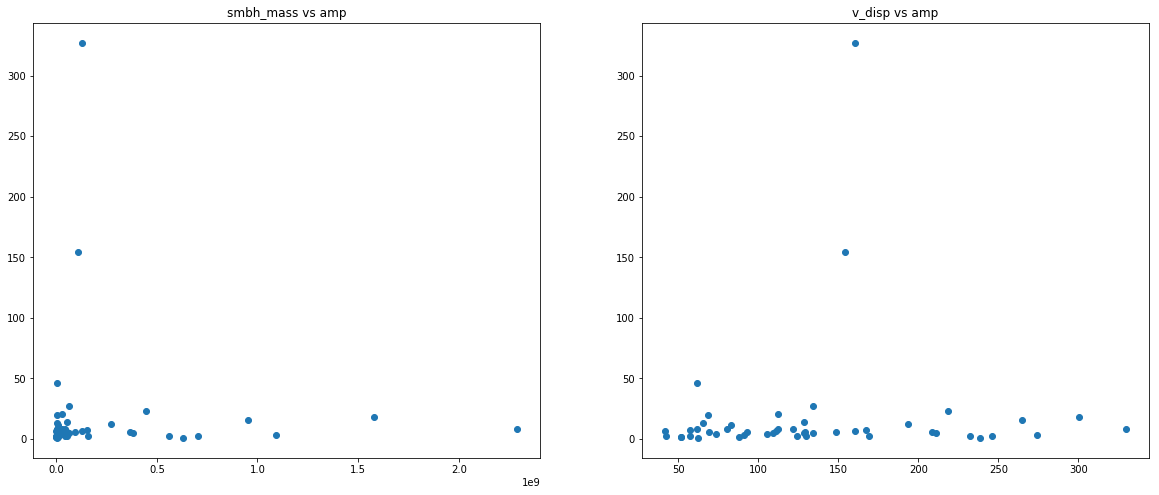

In [25]:
data_path = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma_green/results.csv' )
data = pd.read_csv(g, delimiter = ',')
sdss = data['SDSS Name']
redshift = data['Redshift']
d = data['Distance (Mpc)']
amp = data['Gaussian Amplitude (ergs/cm^2/A/spaxel)']
amp_err = data['Gaussian Amplitude Error (ergs/cm^2/A/spaxel)']
cen = data['Gaussian Centroid (A)']
cen_err = data['Gaussian Centroid Error (A)']
gau_sig = data['Gaussian Sigma (A)']
gau_sig_err = data['Gaussian Sigma Error (A)']
sig = data['Sigma (km/s)']
v = data['Measured Velocity (km/s)'] 
smbh_mass = data['SMBH Mass(Solar Masses)']
sersic_mass = data['Sersic Mass (Solar Masses)']
v_disp = data['Velocity Dispersion (km/s)']
sfr = data['SFR (h-2 Msun/yr)']

f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))

ax1.scatter (smbh_mass, amp)
ax1.set_title('smbh_mass vs amp')
ax2.scatter (v_disp, amp)
ax2.set_title('v_disp vs amp')
ax3.scatter (amp, sfr)
ax3.set_title('amp vs sfr')
ax4.scatter (smbh_mass, sfr)
ax4.set_title('smbh_mass vs sfr')


In [ ]:
df = pd.read_csv('/Users/jamesnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/final/3_sigma_2000_FWHM_Gau/output.csv')
output = '/Users/jamesnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/final/3_sigma_2000_FWHM_Gau/output.csv'
k = open(output)
firstline = True
for line in k:
    if firstline:    #skip first line
        firstline = False
        continue
total = df.iloc[0:,1:6].sum(axis = 1)
c.insert(0,'Total Detection Counts',total)
c.sort_values(['Total Detection Counts'], axis=0, 
                 ascending=False, inplace=True) 
c.to_csv(output, index=False )


In [ ]:
def iau (name):

    emline = Fe_VII_3
    number = 15
    number2 = 15  
    name2 = ' Fe VII 3 '
    name6 = 'Fe VII 3 '
    name8 = 'FeVII3'
    number10 = 50
    
    drpall = fits.open('drpall-v2_4_3.fits') #Opening drpall file
    tbdata = drpall[1].data #Accessing drpall data
    ind = np.where(tbdata['nsa_iauname'] == name)
    plateifu1 = tbdata['plateifu'][ind][0]
    hdulist = fits.open('manga-%s-LOGCUBE-VOR10-GAU-MILESHC.fits' % plateifu1) #Opening fits file
    flux = hdulist[1].data.sum(axis = (1,2)) #Importing Flux Values 
    wavelength_1 = hdulist[4].data #Importing Wavelength Values
    drpall = fits.open('drpall-v2_4_3.fits') #Opening drpall file
    tbdata = drpall[1].data #Accessing drpall data
    ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
    iau = tbdata['nsa_iauname'][ind][0]
    dir = '/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/FeVII3_3sigma/%sFeVII3/' % iau
    c = 299792 #speed of light km/s 
#     if not os.path.exists(dir):
#         os.makedirs(dir)
    
    # get a map
    maps = Maps(plateifu=plateifu1, mode = 'remote')

    # make a standard 3-plot BPT and retrieve the classifications
    #masks, fig, axes = maps.get_bpt()

    # save the plot
    #fig.savefig(iau + '3_plot_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

    # make a BPT classification without OI
    masks, fig, axes = maps.get_bpt(use_oi=False)
    # save the plot
    #fig.savefig(dir + iau + 'no_OI_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

    wavelength = wavelength_1/(tbdata['z'][ind][0] + 1)
    #wavelength = hdulist[4].data
    wavelength_absolute = np.abs(wavelength - emline) 
    wavelength_min = np.argmin(wavelength_absolute)

    #Spectrum parameters
    w_i = number #Bounds of fit
    z_i = number10 #Wider fit
    y_0 = wavelength_min - w_i #Setting lower bound for linear fit
    y_1 = wavelength_min + w_i #Setting upper bound for linear fit
    z_0 = wavelength_min - z_i #Setting lower bound for linear fit
    z_1 = wavelength_min + z_i #Setting upper bound for linear fit
    wavelength_range = wavelength[y_0:y_1] #Setting range for values to plot
    flux_range = flux[y_0:y_1] #Setting range for values to plot
    wavelength_scope = wavelength[z_0:z_1]
    flux_scope = flux[z_0:z_1]

    #Performing linear fit
    l_i = number2 #Bounds of fit
    x_0 = wavelength_min - l_i #Setting lower bound for linear fit
    x_1 = wavelength_min + l_i #Setting upper bound for linear fit
    wavelength_bounds = wavelength[x_0:x_1] #Inputting bounds into wavelength array
    wavelength_mask = np.ma.masked_array(wavelength_bounds, 
                                         (wavelength_bounds != wavelength_bounds[0]) 
                                     & (wavelength_bounds != wavelength_bounds[-1])) #Masking all but first and last values of the array
    wavelength_compressed = wavelength_mask.compressed() #Compressing the array to only fit using the two values
    flux_bounds = flux[x_0:x_1] #Determining flux window for linear fit
    flux_mask = np.ma.masked_array(flux_bounds, (flux_bounds != flux_bounds[0]) #Selecting two points for linear fit.
                               & (flux_bounds != flux_bounds[-1]))
    flux_compressed = flux_mask.compressed() #Compressing the data
    polyfit = np.polyfit(wavelength_compressed,flux_compressed, 1) #Fitting the line to the data
    fit = np.poly1d(polyfit)
    flux_linear = fit[1]*wavelength_bounds + fit[0] #Determining linear fit parameters
    flux_correction = flux_bounds - flux_linear #Correcting for continuum

    def gaus(x,amp,x0,sigma, m, c):
        return amp*np.exp(-(x-x0)**2/(2*sigma**2)) + m*x + c #Defining Gaussian function
    for i in flux_correction[l_i:]:
        if i < 0.659*flux_correction[l_i]:
            s = np.abs(flux_correction - i)
            s2 = np.argmin(s)
            sigma_test = wavelength_bounds[s2] - wavelength_bounds[l_i]
            break

    amplitude = np.argmax(flux_correction) #Making amplitude prediction
    central_wavelength = wavelength[wavelength_min] #Making central wavelength prediction
    offset = np.argmin(flux_bounds) #Making offset prediction
    wavelength_test = np.arange(wavelength_bounds[0],wavelength_bounds[29], 0.25)
    popt, pcov = curve_fit(gaus,wavelength_bounds, #Inputting predictions into fit
                       flux_correction, 
                       p0=[flux_correction[amplitude], 
                           central_wavelength, sigma_test, fit[1], fit[0]])
    emission_legend = AnchoredText('[FeVII] $\lambda$3760', loc=1)
#     #print (wavelength_range)
#     plt.figure(figsize=(10,8))
#     plt.plot(wavelength_scope, flux_scope, 'b', label = 'Data')
#     plt.plot (wavelength_range, flux_correction, 'b+:', label = 'Continuum Subtracted Data')
#     plt.title(iau + ' (z = ' 
#               + str(tbdata['z'][ind][0]) + ')')
#     plt.ylabel('Flux', fontsize = 10)
#     plt.xlabel('Wavelength ($\AA$)', fontsize = 10)
#     plt.plot(wavelength_test, 
#              gaus(wavelength_test, *popt), 'r-', label = 'Gaussian Fit')
#     plt.axvline(x = wavelength[x_0], linestyle = '--', color = 'k')
#     plt.axvline(x = wavelength[x_1-1], linestyle = '--', color = 'k')
#    # plt.ylim(0)
#     plt.xlim(wavelength[z_0],wavelength[z_1] - 1)
#     plt.gca().add_artist(emission_legend)
#     #plt.legend(loc = 3)
#     #dir = '/Users/jamesnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/wavelength_vs_flux/no_threshold/%s/' % tbdata['nsa_iauname'][ind][0]
#     #dir = '/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/final/3_sigma_2000_FWHM/%s/' % tbdata['nsa_iauname'][ind][0]
#     #plt.savefig(dir + iau + '_' + name8 + '.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
#     plt.show()

#     #os.remove(fitsName)

#     i,o,p = hdulist[1].data.shape
#     em_all = np.empty((2*l_i, o, p))
#     for i, value in zip(range(2*l_i), range (x_0, x_1)):
#         em_all[i, :, :] = hdulist[1].data[value,:,:]
#     em_sum = np.sum(em_all, axis = 0)

#     plt.imshow(np.fliplr(em_sum), cmap = 'magma')
#     cbar = plt.colorbar()
#     cbar.set_label('Flux')
#     #plt.axis('off')
#     plt.title(iau + name2)
#     #plt.xlabel('Right Ascension')
#     #plt.ylabel('Declination')
#    # plt.savefig(dir + iau + '_' + name8 + '_flux_map.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
#     plt.show()
    return;
# iau(name='J024603.36+001328.3')
# #iau(name='J031953.70-010845.1')
# iau(name='J110350.86+230023.3')
# iau(name='J115110.60+451322.3')
# iau(name='J131842.21+325507.2')
# iau(name='J145123.60+512833.9')
# iau(name='J155758.99+414728.3')
# iau(name='J160127.80+422317.5')
# iau(name='J162843.13+490339.8')
# iau(name='J170900.44+345417.2')
# iau(name='J213041.43+010021.2')
#iau(name='J162813.89+393347.7')
#iau(name='J151806.10+424438.0')
#iau(name='J171017.77+341427.0')



In [26]:

def emission(emline, bounds, emline_name):
    #for fitsName in glob.glob('output/*.fits'):
    for fitsName in glob.glob('output/dock/dock_6374/*.fits'):   
        hdulist = fits.open(fitsName) 
        wavelength_import = hdulist[4].data #Importing Wavelength Values
        flux_import = hdulist[1].data

        drpall = fits.open('drpall-v2_5_3.fits') #Opening drpall file
        tbdata = drpall[1].data #Accessing drpall data
        ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
        iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
        plateifu1 = tbdata['plateifu'][ind][0]
        sersic_mass = tbdata['nsa_sersic_mass'][ind][0] #Stellar mass from K-correction fit in h-2 solar masses to sersic magnitudes. 

        dapall = fits.open('dapall-v2_5_3-2.3.0.fits') #Opening dapall file
        tbdata_1 = dapall[1].data #Accessing dapall data
        ind_1 = np.where(tbdata_1['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
        velocity_dispersion = tbdata_1['STELLAR_SIGMA_1RE'][ind][0] 
        smbh_mass = (3.1*(velocity_dispersion/200)**4)*(10**8)
        distance = ((tbdata['z'][ind][0])*c)/H_0
        sfr = tbdata_1['SFR_1RE'][ind][0] 

        wavelength = wavelength_import/(tbdata['z'][ind][0] + 1)

        if emline == FeVII_3586 and tbdata['z'][ind][0] < 0.0136642:
            hdulist.close()
            drpall.close()  
            continue

        if emline == NeV_3346 and tbdata['z'][ind][0] < 0.0861153:
            hdulist.close()
            drpall.close()  
            continue

        index1,index2,index3 = flux_import.shape
        cp = int(index2/2)
        cp_down = cp-3
        cp_up = cp+3
        pd = int(index3/2)
        p_down = pd-3
        p_up = pd+3

        #Nuclear region flux
        flux_nuclear_dimensions = flux_import[:,cp_down:cp_up,p_down:p_up]
        flux_nuclear_sum = flux_nuclear_dimensions.sum(axis = (0))
        flux = flux_nuclear_dimensions.sum(axis = (1, 2))

        #Galaxy flux
        flux_galaxy = flux_import.sum(axis = (0))
        flux_galaxy_1d = flux_import.sum(axis = (1,2))

        #Defining neighboring wavelengths
        wavelength_absolute = np.abs(wavelength - emline) 
        wavelength_min = np.argmin(wavelength_absolute)

        #FeVII_3076 Neighboring Lines
        wavelength_oii1 = np.abs(wavelength - OII_1) 
        wavelength_min_oii1 = np.argmin(wavelength_oii1)
        wavelength_oii2 = np.abs(wavelength - OII_2) 
        wavelength_min_oii2 = np.argmin(wavelength_oii2)
        wavelength_hei = np.abs(wavelength - He_I) 
        wavelength_min_hei = np.argmin(wavelength_hei)

        #FeVII_6086 Neighboring Lines
        wavelength_na = np.abs(wavelength - Na) 
        wavelength_min_na = np.argmin(wavelength_na) 

        #FeX_6374 Neighboring Lines
        wavelength_oi1 = np.abs(wavelength - OI_1) 
        wavelength_min_oi1 = np.argmin(wavelength_oi1)
        wavelength_oi2 = np.abs(wavelength - OI_2) 
        wavelength_min_oi2 = np.argmin(wavelength_oi2)
        wavelength_ni = np.abs(wavelength - NI) 
        wavelength_min_ni = np.argmin(wavelength_ni)
        wavelength_nii1 = np.abs(wavelength - NII_1) 
        wavelength_min_nii1 = np.argmin(wavelength_nii1)
        wavelength_nii2 = np.abs(wavelength - NII_2) 
        wavelength_min_nii2 = np.argmin(wavelength_nii2)
        wavelength_halpha = np.abs(wavelength - H_Alpha) 
        wavelength_min_halpha = np.argmin(wavelength_halpha)

        #NeV_3346 Neighboring Lines
        wavelength_nevi = np.abs(wavelength - Ne_VI) 
        wavelength_min_nevi = np.argmin(wavelength_nevi)

        #H-Alpha Neighboring Lines
        wavelength_oiii3 = np.abs(wavelength - OIII_3) 
        wavelength_min_oiii3 = np.argmin(wavelength_oiii3)

        #Determining observed (for vmeasured value)
    #         lambda_obs = (tbdata['z'][ind][0] + 1)*emline
    #         wavelength_absolute = np.abs(wavelength - lambda_obs) 
    #         wavelength_min = np.argmin(wavelength_absolute)

        #Spectrum parameters
        x_0, x_1 = wavelength_min - bounds, wavelength_min + bounds #Setting lower bound for linear fit
        if x_0 < 0:
            x_0 = 0
        #Setting upper bound for linear fit
        z_1_2 = x_0 - 10*bounds
        if z_1_2 < 0:
            z_1_2 = 0
        x_1_2 = x_1 + 10*bounds

        wavelength_bounds_total = wavelength[z_1_2:x_1_2] 
        wavelength_total = np.abs(wavelength_bounds_total - emline) 
        wavelength_min_total = np.argmin(wavelength_total)

        wavelength_mask_total = np.ma.masked_array(wavelength_bounds_total,
                                             (wavelength_bounds_total != wavelength_bounds_total[0])& 
                                             (wavelength_bounds_total != wavelength_bounds_total[-1])) 
        wavelength_compressed_total = wavelength_mask_total.compressed() 

        flux_bounds_total = flux[z_1_2:x_1_2] 
        flux_mask_total = np.ma.masked_array(flux_bounds_total, (flux_bounds_total != flux_bounds_total[0]) 
                                   & (flux_bounds_total != flux_bounds_total[-1]))
        flux_compressed_total = flux_mask_total.compressed() 

        if flux_compressed_total.shape[0] == 3:
            print ('duplicate')
            flux_1,flux_2 = flux_compressed_total[0],flux_compressed_total[2]
            flux_compressed_total = [flux_1, flux_2]

        if flux_compressed_total[0] != 0:

            polyfit_total = np.polyfit(wavelength_compressed_total,flux_compressed_total, 1) #Fitting the line to the data
            fit_total = np.poly1d(polyfit_total)
            flux_linear_total = fit_total[1]*wavelength_bounds_total + fit_total[0] #Determining linear fit parameters
            flux_correction_total = flux_bounds_total - flux_linear_total #Correcting for continuum

            for i in flux_correction_total:
                if i < 0:
                    negative = np.argmin(flux_correction_total)
                    flux_correction_total = flux_correction_total + abs(flux_correction_total[negative])
                    break

            q_0, q_1 = wavelength_min_total - bounds, wavelength_min_total + bounds
            if q_0 < 0:
                q_0 = 0
            wavelength_bounds = wavelength_bounds_total[q_0:q_1]
            flux_bounds = flux_correction_total[q_0:q_1]

            wavelength_bounds_min = np.abs(wavelength_bounds - emline) 
            wavelength_bounds_min_total = np.argmin(wavelength_bounds_min)

            wavelength_mask = np.ma.masked_array(wavelength_bounds,
                                             (wavelength_bounds != wavelength_bounds[0])& 
                                             (wavelength_bounds != wavelength_bounds[-1])) 
            wavelength_compressed = wavelength_mask.compressed() 

            flux_mask = np.ma.masked_array(flux_bounds, (flux_bounds != flux_bounds[0]) 
                                   & (flux_bounds != flux_bounds[-1]))
            flux_compressed = flux_mask.compressed() 

            if flux_compressed.shape[0] == 3:
                print ('duplicate')
                flux_compressed = [flux_1, flux_2]

            if flux_compressed[0] != 0:

                polyfit = np.polyfit(wavelength_compressed,flux_compressed, 1) #Fitting the line to the data
                fit = np.poly1d(polyfit)
                flux_linear = fit[1]*wavelength_bounds + fit[0] #Determining linear fit parameters
                avg_flux = np.average(flux_linear)

            x_1_9 = x_1 + 4*bounds
            flux_sigma_bounds_1 = flux[x_1 + 5: x_1_9 + 5]
            f_std = np.std(flux_sigma_bounds_1)
            flux_sigma = 5*(f_std)
            flux_sigma_1 = 1*(f_std)

            if len(fitsName) == 72:
                print ('\n' + iau + ' ('+ fitsName[28:37] + ') ' + emline_name + ' ' +
                '\n' + 'Five Sigma (ergs/cm^2/A/spaxel) = ' + str(flux_sigma))
            if len(fitsName) == 73:
                print ('\n' + iau + ' (' + fitsName[28:38] + ') ' + emline_name + ' ' +
                '\n' + 'Five Sigma (ergs/cm^2/A/spaxel) = ' + str(flux_sigma))
            if len(fitsName) == 74:
                print ('\n' + iau + ' (' + fitsName[28:39] + ') ' + emline_name + ' ' +
                '\n' + 'Five Sigma (ergs/cm^2/A/spaxel) = ' + str(flux_sigma))

            def gaus(x,amp,mu,sigma, m, c):
                return amp*np.exp(-(x-mu)**2/(2*sigma**2)) + m*x + c #Defining Gaussian function

            def double_gaussian(x,amp_ems,mu1,sigma1,m1,c1,amp2,mu2,sigma2,m2,c2):
                return gaus(x,amp_ems,mu1,sigma1,m1,c1) + gaus(x,amp2,mu2,sigma2,m2,c2)

            wavelength_emission = np.argmax(flux_bounds)
            amp_ems = flux_bounds[wavelength_emission]
            wavelength_absorption = np.argmin(flux_bounds)
            amp_abs = flux_bounds[wavelength_absorption]
            amp_abs_1 = -(avg_flux - amp_abs)
            sigma_abs_1 = avg_flux - flux_sigma_1
            sigma_abs_5 = avg_flux - flux_sigma
            sigma_ems = avg_flux + flux_sigma

            o1_wavelength_total = np.abs(wavelength_bounds - OI_2) 
            o1_wavelength_min_total = np.argmin(o1_wavelength_total)
            amp_o1 = flux_bounds[o1_wavelength_min_total]
            mu_o1 = wavelength_bounds[o1_wavelength_min_total]
            sigma_guess_o1 = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu_o1)**2)/np.sum(flux_bounds))

            mu_abs = wavelength_bounds[wavelength_absorption]
            mu_ems = wavelength_bounds[wavelength_emission]
            mu = np.sum(wavelength_bounds*flux_bounds)/np.sum(flux_bounds)
            
            sigma_guess_abs = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu_abs)**2)/np.sum(flux_bounds))
            sigma_guess_ems = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu_ems)**2)/np.sum(flux_bounds))
            sigma_guess = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu)**2)/np.sum(flux_bounds))
            amp = flux_bounds[wavelength_bounds_min_total]

            if amp_abs < sigma_abs_5:
                hdulist.close()
                drpall.close() 
                print ('5 Sigma Absorption Line Error')
                continue

            if amp_abs < sigma_abs_1 and amp_ems < sigma_ems:

                try:
                    popt, pcov = curve_fit(gaus,wavelength_bounds, flux_bounds,  
                               p0=[amp_abs_1, mu, sigma_guess, fit[1], 
                                   fit[0]])
                except RuntimeError:
                    popt, pcov = curve_fit(gaus,wavelength_bounds, flux_bounds,  
                               p0=[amp_abs_1, mu, sigma_guess, 1, 
                                   1])

                print (emline_name + ' Absorption Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]))

                if popt[0] < 0:
                    hdulist.close()
                    drpall.close() 
                    print ('Absorption Line Error')
                    continue

                else:
                    try:
                        popt, pcov = curve_fit(gaus,wavelength_bounds, flux_bounds,  
                                   p0=[amp_ems, mu, sigma_guess, fit[1], 
                                       fit[0]])
                    except RuntimeError:
                        hdulist.close()
                        drpall.close() 
                        print ('RuntimeError')

                    try:
                        perr = np.sqrt(np.diag(pcov))
                    except RuntimeWarning:
                        perr = 0
                        print ('RuntimeWarning')
                        
                    residuals = flux_bounds - gaus(wavelength_bounds, *popt) #Determines the uncertainty in ydata

                    chi_squared =  np.sum(((residuals)** 2)/(gaus(wavelength_bounds, *popt)))
                    reduced_chi_squared = chi_squared / (len(popt) - 1)

                    print ('Chi Squared test = ' +  str(chi_squared) + '\n' + 'Reduced Chi Squared = ' 
                           + str(reduced_chi_squared))
                        
                    print (emline_name + ' Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]))

            else:
                try:
                    popt, pcov = curve_fit(gaus,wavelength_bounds, flux_bounds,  
                               p0=[amp_ems, mu, sigma_guess, fit[1], 
                                   fit[0]])
                except RuntimeError:
                    hdulist.close()
                    drpall.close()
                    print ('RuntimeError ')
                    continue
                    

                try:
                    perr = np.sqrt(np.diag(pcov))
                except RuntimeWarning:
                    perr = 0
                    print ('RuntimeWarning')
                    
                residuals = flux_bounds - gaus(wavelength_bounds, *popt) #Determines the uncertainty in ydata

                chi_squared =  np.sum(((residuals)** 2)/(gaus(wavelength_bounds, *popt)))
                reduced_chi_squared = chi_squared / (len(popt) - 1)

                print ('Chi Squared test = ' +  str(chi_squared) + '\n' + 'Reduced Chi Squared = ' 
                       + str(reduced_chi_squared))
                        
                print (emline_name + ' Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]))

                if emline == FeX_6374:    
                    try:
                        popt_dg, pcov_dg = curve_fit(double_gaussian,wavelength_bounds, flux_bounds,  
                                       p0=[amp,mu,sigma_guess,fit[1],fit[0],amp_o1,mu_o1,sigma_guess_o1,fit[1],fit[0]]) 
                    except RuntimeError:
                        hdulist.close()
                        drpall.close() 
                        print ('RuntimeError')
                        continue

                    try:
                        perr_dg = np.sqrt(np.diag(pcov_dg))
                    except RuntimeWarning:
                        hdulist.close()
                        drpall.close()
                        print ('RuntimeWarning')
                        continue
                        
                    residuals_dg = flux_bounds - double_gaussian(wavelength_bounds, *popt_dg) #Determines the uncertainty in ydata

                    chi_squared_dg =  np.sum(((residuals_dg)** 2)/(double_gaussian(wavelength_bounds, *popt_dg)))
                    reduced_chi_squared_dg = chi_squared_dg / (len(popt_dg) - 1)

                    print ('Double Gaussian Chi Squared = ' +  str(chi_squared_dg) + '\n' + 'Double Gaussian Reduced Chi Squared = ' 
                           + str(reduced_chi_squared_dg))

                    print (emline_name + ' OI Flux (ergs/cm^2/A/spaxel) = ' + str(popt_dg[5]) + '\n'
                           + emline_name + ' FeX Flux (ergs/cm^2/A/spaxel) = ' + str(popt_dg[0]))

                    velocity_meas_dg = c*((popt_dg[1] - emline)/emline)
                    velocity_sys_dg = c*tbdata['z'][ind][0]
                    velocity_off_dg = velocity_sys_dg - velocity_meas_dg
                    sigma_dg = c*(abs(popt_dg[2])/emline)
                    fwhm_dg = sigma_dg*2.355
                    ip = 262.1
                    
                    #if sigma_dg > 0 and sigma_dg < 450 and popt_dg[0] > flux_sigma and mu-15 < popt_dg[1] < mu+15 and popt_dg[0] > 3*perr_dg[0]:

                    newpath = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline_name + '%s/'%iau
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    f = open(newpath + "dg_data.csv","w+")
                    f.write('SDSS Name' + ',' + 'Redshift' + ',' + 'Distance (Mpc)' + ',' + '5 Sigma Threshold (ergs/cm^2/A/spaxel)'
                             + ',' + 'Gaussian Amplitude (ergs/cm^2/A/spaxel)' + ',' 
                            + 'Gaussian Amplitude Error (ergs/cm^2/A/spaxel)'+ ',' 
                            + 'Gaussian Centroid (A)' + ',' + 'Gaussian Centroid Error (A)' + ',' 
                            + 'Gaussian Sigma (A)' + ',' 
                            + 'Gaussian Sigma Error (A)'+ ','+ 'Sigma (km/s)' + ',' + 'FWHM (km/s)' + ',' + 'Measured Velocity (km/s)' 
                            + ',' + 'SMBH Mass(Solar Masses)' + ',' + 'Sersic Mass (Solar Masses)'+  ',' + 'Velocity Dispersion (km/s)' + ','
                             + 'SFR (h-2 Msun/yr)' + ',' + 'Chi Squared' + ',' + 'Reduced Chi Squared' +  ',' + 'Ionization Energy (eV)'+
                            '\n' + str(iau) + ',' + str(tbdata['z'][ind][0]) + ',' + str(distance) + ',' + str(flux_sigma) + ',' 
                            + str(popt_dg[0])+ ',' + str(perr_dg[0]) 
                            + ','  + str(popt_dg[1]) + ',' + str(perr_dg[1]) +  ','  + str(popt_dg[2]) + ',' + str(perr_dg[2]) + ',' 
                            + str(sigma_dg) + ','  + str(fwhm_dg) + ',' + str(velocity_meas_dg)+ ',' + str(smbh_mass) + ',' + str(sersic_mass) 
                            + ','  + str(velocity_dispersion) + ',' + str(sfr) + ',' + str(chi_squared_dg) + ',' + str(reduced_chi_squared_dg) 
                            + ',' + str(ip))
                    f.close()

                    fig = plt.figure(figsize=(15,10))
                    ax1 = plt.axes()  
                    ax2 = plt.axes([0.18, 0.7, 0.15, 0.15])
                    ax1.plot(wavelength_bounds_total, flux_correction_total, 'b', label = 'Data')

                    ax2.plot(wavelength_bounds, residuals, 'k')
                    ax2.set_title('Residuals')
                    ax2.set_ylabel('Flux')
                    ax2.set_xlabel(r'Wavelength ($\AA$)')

                    if len(fitsName) == 57:
                        ax1.set_title(iau + ' ('+ fitsName[13:22] + ')')
                    if len(fitsName) == 58:
                        ax1.set_title(iau + ' ('+ fitsName[13:23] + ')')
                    if len(fitsName) == 59:
                        ax1.set_title(iau + ' ('+ fitsName[13:24] + ')')

                    ax1.set_ylabel('Flux', fontsize = 15)
                    ax1.set_xlabel(r'Wavelength ($\AA$)', fontsize = 15)
                    r = wavelength_bounds_total.shape
                    ax1.set_xlim(wavelength_bounds_total[1],wavelength_bounds_total[r[0] - 1])

                    marker = np.argmin(flux_correction_total)
                    marker_min = np.argmax(flux_correction_total)
                    marker_threshold = -(0.035*flux_correction_total[marker_min])

                    ax1.text(wavelength[x_1 + 15], marker_threshold, 'Neighboring Continuum', fontsize=9)


                    ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                    ax1.text(wavelength[wavelength_min-3], marker_threshold, 'FeX', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_oi2],flux_correction_total[marker], marker='|', color = 'purple', linestyle='None')
                    ax1.text(wavelength[wavelength_min_oi2-2], marker_threshold, 'OI', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_oi1],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                    ax1.text(wavelength[wavelength_min_oi1-2], marker_threshold, 'OI', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_ni],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                    ax1.text(wavelength[wavelength_min_ni-2], marker_threshold, 'NI', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_nii1],flux_correction_total[marker], marker='|', color = 'magenta', linestyle='None')
                    ax1.text(wavelength[wavelength_min_nii1-3], marker_threshold, 'NII', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_nii2],flux_correction_total[marker], marker='|', color = 'cyan', linestyle='None')
                    ax1.text(wavelength[wavelength_min_nii2-3], marker_threshold, 'NII', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_halpha],flux_correction_total[marker], marker='|', color = 'pink', linestyle='None')
                    ax1.text(wavelength[wavelength_min_halpha-6], marker_threshold, 'Halpha', fontsize=9)


                    ax1.axvline(x = wavelength[x_0], linestyle = '--', color = 'r')
                    ax1.axvline(x = wavelength[x_1], linestyle = '--', color = 'r')
                    ax1.axvline(x = wavelength[x_1 + 5], linestyle = '-', color = 'k')
                    ax1.axvline(x = wavelength[x_1_9 + 5], linestyle = '-', color = 'k')

                    p_i = wavelength_bounds.shape[0]
                    wavelength_range = np.arange(wavelength_bounds[0],wavelength_bounds[p_i-1], 0.25)

                    ax1.plot(wavelength_bounds,double_gaussian(wavelength_bounds, *popt_dg), 'r-', label = 'Gaussian')

                    ax1.legend(loc = 1)

                    fig.savefig(newpath + iau + '_' + emline_name + '_dg.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0.1)
                    #plt.show()
                    plt.close()

                    #Continuum Flux Maps
                    f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                    cax1 = ax1.imshow(flux_galaxy, cmap='gist_heat', origin = 'lower', norm=LogNorm())
                    ax1.set_title(iau + ' Continuum Galaxy Flux Map')
                    ax1.set_xlabel('Spaxels')
                    ax1.set_ylabel('Spaxels')
                    f.colorbar(cax1, ax = ax1, label = 'Flux')
                    vmin, vmax = cax1.get_clim()
                    cax2 = ax2.imshow(flux_nuclear_sum, cmap='gist_heat', origin = 'lower', norm=LogNorm())
                    ax2.set_title(iau + ' Continuum Nuclear Flux Map')
                    ax2.set_xlabel('Spaxels')
                    ax2.set_ylabel('Spaxels')
                    f.colorbar(cax2, ax = ax2, label = 'Flux')
                    f.savefig(newpath +  iau + '_' + 'continuum_flux_maps_dg.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                    #plt.show()
                    plt.close()

                    #Emission Line Flux Maps
                    f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                    cax1 = ax1.imshow(flux_import[x_0:x_1, :, :].sum(axis = 0), cmap='gist_heat', origin = 'lower', norm=LogNorm(), vmax = vmax)
                    ax1.set_title(iau  + ' ' + emline_name + ' ' + ' Galaxy Flux Map')
                    ax1.set_xlabel('Spaxels')
                    ax1.set_ylabel('Spaxels')
                    f.colorbar(cax1, ax = ax1, label = 'Flux')
                    cax2 = ax2.imshow(flux_nuclear_dimensions[x_0:x_1, :, :].sum(axis = (0)), cmap='gist_heat', origin = 'lower', norm=LogNorm(), vmax = vmax)
                    ax2.set_title(iau  + ' ' + emline_name + ' ' + ' Nuclear Flux Map')
                    ax2.set_xlabel('Spaxels')
                    ax2.set_ylabel('Spaxels')
                    f.colorbar(cax2, ax = ax2, label = 'Flux')
                    f.savefig(newpath +  iau + '_' + 'emission_line_flux_maps_dg.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                    #plt.show()
                    plt.close() 

                        
            velocity_meas = c*((popt[1] - emline)/emline)
            velocity_sys = c*tbdata['z'][ind][0]
            velocity_off = velocity_sys - velocity_meas
            sigma = c*(abs(popt[2])/emline)
            fwhm = sigma*2.355
            
            if emline == FeVII_3586 or FeVII_3760 or FeVII_6086:
                ip = 124.98  
            if emline == FeX_6374:
                ip = 262.1
            if emline == NeV_3346:
                ip = 126.21
                
            # sigma_threshold = ((2000/2.355)/c)*(wavelength[wavelength_min])
            if sigma > 0 and sigma < 450 and popt[0] > flux_sigma and mu-15 < popt[1] < mu+15 and popt[0] > 3*perr[0]:

                newpath = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline_name + '%s/'%iau
                if not os.path.exists(newpath):
                    os.makedirs(newpath)
                f = open(newpath + "data.csv","w+")
                f.write('SDSS Name' + ',' + 'Redshift' + ',' + 'Distance (Mpc)' + ',' + '5 Sigma Threshold (ergs/cm^2/A/spaxel)'
                                 + ',' + 'Gaussian Amplitude (ergs/cm^2/A/spaxel)' + ',' 
                                + 'Gaussian Amplitude Error (ergs/cm^2/A/spaxel)'+ ',' 
                                + 'Gaussian Centroid (A)' + ',' + 'Gaussian Centroid Error (A)' + ',' 
                                + 'Gaussian Sigma (A)' + ',' 
                                + 'Gaussian Sigma Error (A)'+ ','+ 'Sigma (km/s)' + ',' + 'FWHM' + ',' + 'Measured Velocity (km/s)' 
                                + ',' + 'SMBH Mass(Solar Masses)' + ',' + 'Sersic Mass (Solar Masses)'+  ',' + 'Velocity Dispersion (km/s)' + ','
                                 + 'SFR (h-2 Msun/yr)' + ',' + 'Chi Squared' + ',' + 'Reduced Chi Squared' +  ',' + 'Ionization Energy (eV)'+
                                '\n' + str(iau) + ',' + str(tbdata['z'][ind][0]) + ',' + str(distance) + ',' + str(flux_sigma) + ',' 
                                + str(popt[0])+ ',' + str(perr[0]) 
                                + ','  + str(popt[1]) + ',' + str(perr[1]) +  ','  + str(popt[2]) + ',' + str(perr[2]) + ',' 
                                + str(sigma) + ','  + str(fwhm) + ',' + str(velocity_meas)+ ',' + str(smbh_mass) + ',' + str(sersic_mass) 
                                + ','  + str(velocity_dispersion) + ',' + str(sfr) + ',' + str(chi_squared) + ',' + str(reduced_chi_squared) 
                                + ',' + str(ip))
                f.close()

                fig = plt.figure(figsize=(15,10))
                ax1 = plt.axes()  
                ax2 = plt.axes([0.18, 0.7, 0.15, 0.15])
                ax1.plot(wavelength_bounds_total, flux_correction_total, 'b', label = 'Data')

                ax2.plot(wavelength_bounds, residuals, 'k')
                ax2.set_title('Residuals')
                ax2.set_ylabel('Flux')
                ax2.set_xlabel(r'Wavelength ($\AA$)')

                if len(fitsName) == 67:
                    ax1.set_title(iau + ' ('+ fitsName[23:32] + ')')
                if len(fitsName) == 68:
                    ax1.set_title(iau + ' ('+ fitsName[23:33] + ')')
                if len(fitsName) == 69:
                    ax1.set_title(iau + ' ('+ fitsName[23:34] + ')')

                ax1.set_ylabel('Flux', fontsize = 15)
                ax1.set_xlabel(r'Wavelength ($\AA$)', fontsize = 15)
                r = wavelength_bounds_total.shape
                ax1.set_xlim(wavelength_bounds_total[1],wavelength_bounds_total[r[0] - 1])

                marker = np.argmin(flux_correction_total)
                marker_min = np.argmax(flux_correction_total)
                marker_threshold = -(0.035*flux_correction_total[marker_min])

                ax1.text(wavelength[x_1 + 15], marker_threshold, 'Neighboring Continuum', fontsize=9)

                if emline == FeVII_3586:
                    ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                    ax1.text(wavelength[wavelength_min-4], marker_threshold, 'FeVII', fontsize=9)

                if emline == FeVII_3760:
                    ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                    ax1.text(wavelength[wavelength_min-4], marker_threshold, 'FeVII', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_oii1],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                    ax1.text(wavelength[wavelength_min_oii1-1], marker_threshold, 'OII', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_oii2],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                    #ax1.text(wavelength[wavelength_min_oii2-3], marker_threshold, fontsize=9)
                    ax1.plot(wavelength[wavelength_min_hei],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                    ax1.text(wavelength[wavelength_min_hei-3], marker_threshold, 'OII', fontsize=9)


                if emline == FeVII_6086:
                    ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                    ax1.text(wavelength[wavelength_min-4], marker_threshold, 'FeVII', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_na],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                    ax1.text(wavelength[wavelength_min_na-2], marker_threshold, 'Na', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_oi1],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                    ax1.text(wavelength[wavelength_min_oi1-2], marker_threshold, 'OI', fontsize=9)

                if emline == FeX_6374:
                    ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                    ax1.text(wavelength[wavelength_min-3], marker_threshold, 'FeX', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_oi2],flux_correction_total[marker], marker='|', color = 'purple', linestyle='None')
                    ax1.text(wavelength[wavelength_min_oi2-2], marker_threshold, 'OI', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_oi1],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                    ax1.text(wavelength[wavelength_min_oi1-2], marker_threshold, 'OI', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_ni],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                    ax1.text(wavelength[wavelength_min_ni-2], marker_threshold, 'NI', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_nii1],flux_correction_total[marker], marker='|', color = 'magenta', linestyle='None')
                    ax1.text(wavelength[wavelength_min_nii1-3], marker_threshold, 'NII', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_nii2],flux_correction_total[marker], marker='|', color = 'cyan', linestyle='None')
                    ax1.text(wavelength[wavelength_min_nii2-3], marker_threshold, 'NII', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_halpha],flux_correction_total[marker], marker='|', color = 'pink', linestyle='None')
                    ax1.text(wavelength[wavelength_min_halpha-6], marker_threshold, 'Halpha', fontsize=9)

    #                             if emline == OIII_4:
    #                                 plt.plot(wavelength[wavelength_min_oiii3],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
    #                                 plt.text(wavelength[wavelength_min_oiii3-4], marker_threshold, 'OIII', fontsize=9)

                if emline == NeV_3346:
                    ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                    ax1.text(wavelength[wavelength_min-3], marker_threshold, 'NeV', fontsize=9)
                    ax1.plot(wavelength[wavelength_min_nevi],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                    ax1.text(wavelength[wavelength_min_nevi-4], marker_threshold, 'Ne_VI', fontsize=9)

                ax1.axvline(x = wavelength[x_0], linestyle = '--', color = 'r')
                ax1.axvline(x = wavelength[x_1], linestyle = '--', color = 'r')
                ax1.axvline(x = wavelength[x_1 + 5], linestyle = '-', color = 'k')
                ax1.axvline(x = wavelength[x_1_9 + 5], linestyle = '-', color = 'k')

                p_i = wavelength_bounds.shape[0]
                wavelength_range = np.arange(wavelength_bounds[0],wavelength_bounds[p_i-1], 0.25)

                if len(popt) == 10:
                    ax1.plot(wavelength_range,double_gaussian(wavelength_range, *popt), 'r-', label = 'Gaussian')
                else:
                    ax1.plot(wavelength_range,gaus(wavelength_range, *popt), 'r-', label = 'Gaussian')
                ax1.legend(loc = 1)

                fig.savefig(newpath + iau + '_' + emline_name + '.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0.1)
                #plt.show()
                plt.close()

                #Emission Line Flux Maps
                f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                cax1 = ax1.imshow(flux_import[x_0:x_1, :, :].sum(axis = 0), cmap='gist_heat', origin = 'lower')
                ax1.set_title(iau  + ' ' + emline_name + ' ' + ' Galaxy Flux Map')
                ax1.set_xlabel('Spaxels')
                ax1.set_ylabel('Spaxels')
                f.colorbar(cax1, ax = ax1, label = 'Flux')
                cax2 = ax2.imshow(flux_nuclear_dimensions[x_0:x_1, :, :].sum(axis = (0)), cmap='gist_heat', origin = 'lower')
                ax2.set_title(iau  + ' ' + emline_name + ' ' + ' Nuclear Flux Map')
                ax2.set_xlabel('Spaxels')
                ax2.set_ylabel('Spaxels')
                f.colorbar(cax2, ax = ax2, label = 'Flux')
                f.savefig(newpath +  iau + '_' + 'emission_line_flux_maps.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                #plt.show()
                plt.close()

                #Continuum Flux Maps
                f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                cax1 = ax1.imshow(flux_galaxy, cmap='gist_heat', origin = 'lower')
                ax1.set_title(iau + ' Continuum Galaxy Flux Map')
                ax1.set_xlabel('Spaxels')
                ax1.set_ylabel('Spaxels')
                f.colorbar(cax1, ax = ax1, label = 'Flux')
                cax2 = ax2.imshow(flux_nuclear_sum, cmap='gist_heat', origin = 'lower')
                ax2.set_title(iau + ' Continuum Nuclear Flux Map')
                ax2.set_xlabel('Spaxels')
                ax2.set_ylabel('Spaxels')
                f.colorbar(cax2, ax = ax2, label = 'Flux')
                f.savefig(newpath +  iau + '_' + 'continuum_flux_maps.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                plt.close()


                 # get a map
                #maps = Maps(plateifu=plateifu1)

                # make a standard 3-plot BPT and retrieve the classifications
                #masks, fig, axes = maps.get_bpt()

                # save the plot
                #fig.savefig(dir + iau + '_' + '3_plot_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

    #                             # make a BPT classification without OI
    #                             masks, fig, axes = maps.get_bpt(use_oi=False)
    #                             # save the plot
    #                             fig.savefig(dir + iau + 'no_OI_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

            hdulist.close()
            drpall.close()               

    return;


# Calling the function
#         emission(emline = FeVII_3760, 
#                  bounds = 15, 
#                  emline_name = 'FeVII_3760A')
# emission(emline = FeVII_6086, 
#          bounds = 15, 
#          emline_name = 'FeVII_6086A')
# emission(emline = NeV_3346, 
#          bounds = 15,  
#          emline_name = 'NeV_3346.79A')
# emission(emline = FeVII_3586, 
#          bounds = 15, 
#          emline_name = 'FeVII_3586A')
emission(emline = FeX_6374, 
         bounds = 15, 
         emline_name = 'FeX_6374A')
#         emission(emline = H_Beta, 
#                 bounds = 15, 
#                 emline_name = 'HBeta_4862.68A')
#         emission(emline = OIII_4, 
#                 bounds = 15, 
#                 emline_name = 'OIII_4_5008.240A')




J084824.87+535507.4 (8243-1902) FeX_6374A 
Five Sigma (ergs/cm^2/A/spaxel) = 2.4037086963653564

J121248.98+525411.8 (10508-3703) FeX_6374A 
Five Sigma (ergs/cm^2/A/spaxel) = 6.486164927482605
FeX_6374A Absorption Flux (ergs/cm^2/A/spaxel) = -17.374515631526414

J111658.39+231130.4 (8449-6101) FeX_6374A 
Five Sigma (ergs/cm^2/A/spaxel) = 1.9241249561309814
Chi Squared test = 1.5554291
Reduced Chi Squared = 0.38885727524757385
FeX_6374A Flux (ergs/cm^2/A/spaxel) = 2.244354258548863
RuntimeWarning

J133602.84+223801.4 (8311-3704) FeX_6374A 
Five Sigma (ergs/cm^2/A/spaxel) = 6.059409976005554
Chi Squared test = 22.06824
Reduced Chi Squared = 5.517059803009033
FeX_6374A Flux (ergs/cm^2/A/spaxel) = 1.1336604174077423
Double Gaussian Chi Squared = 2.9532142
Double Gaussian Reduced Chi Squared = 0.3281349076165093
FeX_6374A OI Flux (ergs/cm^2/A/spaxel) = -4.853883004531941
FeX_6374A FeX Flux (ergs/cm^2/A/spaxel) = 5.476643547509199

J133412.15+270011.4 (8984-3704) FeX_6374A 
Five Sigma (ergs


J162952.88+242638.4 (9892-6102) FeX_6374A 
Five Sigma (ergs/cm^2/A/spaxel) = 14.986211061477661
Chi Squared test = 3.0718663
Reduced Chi Squared = 0.7679665684700012
FeX_6374A Flux (ergs/cm^2/A/spaxel) = 27.78032139068187
Double Gaussian Chi Squared = 153.31297
Double Gaussian Reduced Chi Squared = 17.034774780273438
FeX_6374A OI Flux (ergs/cm^2/A/spaxel) = -98.76445638747958
FeX_6374A FeX Flux (ergs/cm^2/A/spaxel) = -73.70677858864184

J102843.06+395019.8 (8455-3701) FeX_6374A 
Five Sigma (ergs/cm^2/A/spaxel) = 3.0767688155174255
Chi Squared test = 3.1370244
Reduced Chi Squared = 0.784256100654602
FeX_6374A Flux (ergs/cm^2/A/spaxel) = 6.154805773644756
Double Gaussian Chi Squared = 127.76071
Double Gaussian Reduced Chi Squared = 14.19563462999132
FeX_6374A OI Flux (ergs/cm^2/A/spaxel) = 62.55441478461967
FeX_6374A FeX Flux (ergs/cm^2/A/spaxel) = -112.2181708656616

J082414.30+171955.0 (8241-6102) FeX_6374A 
Five Sigma (ergs/cm^2/A/spaxel) = 3.914841115474701
Chi Squared test = 5.4460

Double Gaussian Chi Squared = 210.20279
Double Gaussian Reduced Chi Squared = 23.355865478515625
Single Gaussian Chi Squared = 396.58478
Single Gaussian Reduced Chi Squared = 99.14619445800781


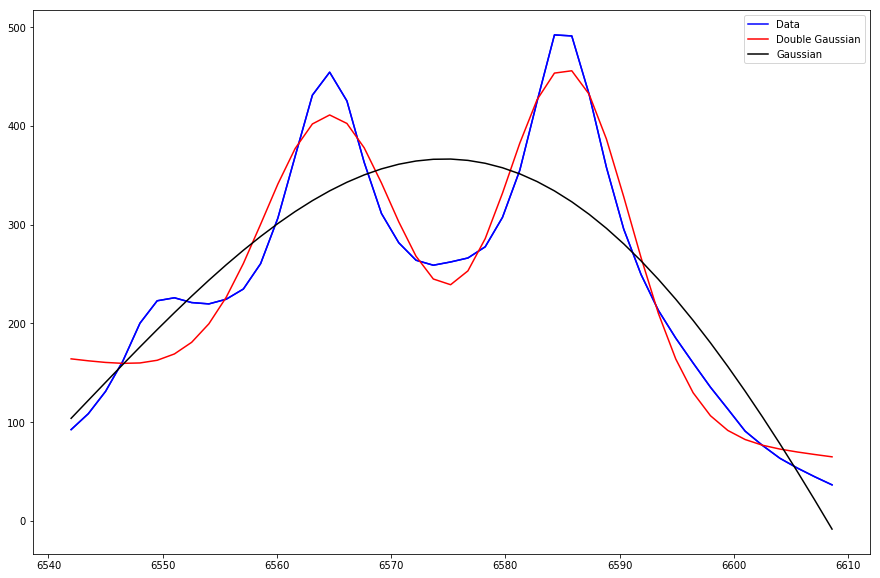

In [17]:

def emission(emline, bounds, emline_name):
    #for fitsName in glob.glob('output/*.fits'):
  #  for fitsName in glob.glob('output/dock_6374/*.fits'):   
    hdulist = fits.open('manga-8715-3702-LOGCUBE-VOR10-MILESHC-MILESHC.fits') 
    wavelength_import = hdulist[4].data #Importing Wavelength Values
    flux_import = hdulist[1].data
    ivar = hdulist[2].data
#     try: 
#         flux_error = np.sqrt(1/ivar)
#     except RuntimeWarning:
#         flux_error = 0

    drpall = fits.open('drpall-v2_5_3.fits') #Opening drpall file
    tbdata = drpall[1].data #Accessing drpall data
    ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
    wavelength = wavelength_import/(tbdata['z'][ind][0] + 1)

    index1,index2,index3 = flux_import.shape
    cp = int(index2/2)
    cp_down = cp-3
    cp_up = cp+3
    pd = int(index3/2)
    p_down = pd-3
    p_up = pd+3

    #Nuclear region flux
    flux_nuclear_dimensions = flux_import[:,cp_down:cp_up,p_down:p_up]
    flux_nuclear_sum = flux_nuclear_dimensions.sum(axis = (0))
    flux = flux_nuclear_dimensions.sum(axis = (1, 2))
    
    flux_nuclear_dimensions_error = ivar[:,cp_down:cp_up,p_down:p_up]
    flux_nuclear_sum_error = flux_nuclear_dimensions_error.sum(axis = (0))
    flux_error = flux_nuclear_dimensions_error.sum(axis = (1, 2))
    

    #Defining neighboring wavelengths
    wavelength_absolute = np.abs(wavelength - emline) 
    wavelength_min = np.argmin(wavelength_absolute)


    #Spectrum parameters
    x_0, x_1 = wavelength_min - bounds, wavelength_min + bounds #Setting lower bound for linear fit
    if x_0 < 0:
        x_0 = 0
    #Setting upper bound for linear fit
    z_1_2 = x_0 - 10*bounds
    if z_1_2 < 0:
        z_1_2 = 0
    x_1_2 = x_1 + 10*bounds

    wavelength_bounds_total = wavelength[z_1_2:x_1_2] 
    wavelength_total = np.abs(wavelength_bounds_total - emline) 
    wavelength_min_total = np.argmin(wavelength_total)

    wavelength_mask_total = np.ma.masked_array(wavelength_bounds_total,
                                         (wavelength_bounds_total != wavelength_bounds_total[0])& 
                                         (wavelength_bounds_total != wavelength_bounds_total[-1])) 
    wavelength_compressed_total = wavelength_mask_total.compressed() 

    flux_bounds_total = flux[z_1_2:x_1_2] 
    flux_bounds_total_error = flux_error[z_1_2:x_1_2] 
    
    flux_mask_total = np.ma.masked_array(flux_bounds_total, (flux_bounds_total != flux_bounds_total[0]) 
                               & (flux_bounds_total != flux_bounds_total[-1]))
    flux_compressed_total = flux_mask_total.compressed() 

    if flux_compressed_total.shape[0] == 3:
        print ('duplicate')
        flux_1,flux_2 = flux_compressed_total[0],flux_compressed_total[2]
        flux_compressed_total = [flux_1, flux_2]

    if flux_compressed_total[0] != 0:

        polyfit_total = np.polyfit(wavelength_compressed_total,flux_compressed_total, 1) #Fitting the line to the data
        fit_total = np.poly1d(polyfit_total)
        flux_linear_total = fit_total[1]*wavelength_bounds_total + fit_total[0] #Determining linear fit parameters
        flux_correction_total = flux_bounds_total - flux_linear_total #Correcting for continuum

        for i in flux_correction_total:
            if i < 0:
                negative = np.argmin(flux_correction_total)
                flux_correction_total = flux_correction_total + abs(flux_correction_total[negative])
                break

        q_0, q_1 = wavelength_min_total - 1*bounds, wavelength_min_total + 2*bounds
        if q_0 < 0:
            q_0 = 0
        wavelength_bounds = wavelength_bounds_total[q_0:q_1]
        flux_bounds = flux_correction_total[q_0:q_1]
        
        flux_bounds_ivar = flux_bounds_total[q_0:q_1]
        flux_bounds_error = np.sqrt(1/flux_bounds_ivar)
        
        wavelength_bounds_min = np.abs(wavelength_bounds - emline) 
        wavelength_bounds_min_total = np.argmin(wavelength_bounds_min)

        wavelength_mask = np.ma.masked_array(wavelength_bounds,
                                         (wavelength_bounds != wavelength_bounds[0])& 
                                         (wavelength_bounds != wavelength_bounds[-1])) 
        wavelength_compressed = wavelength_mask.compressed() 

        flux_mask = np.ma.masked_array(flux_bounds, (flux_bounds != flux_bounds[0]) 
                               & (flux_bounds != flux_bounds[-1]))
        flux_compressed = flux_mask.compressed() 

        if flux_compressed.shape[0] == 3:
            print ('duplicate')
            flux_compressed = [flux_1, flux_2]

        if flux_compressed[0] != 0:

            polyfit = np.polyfit(wavelength_compressed,flux_compressed, 1) #Fitting the line to the data
            fit = np.poly1d(polyfit)
            flux_linear = fit[1]*wavelength_bounds + fit[0] #Determining linear fit parameters
            avg_flux = np.average(flux_linear)

        def gaus(x,amp,mu,sigma,m,b):
            return amp*np.exp(-(x-mu)**2/(2*sigma**2)) + m*x + b  #Defining Gaussian function

        def double_gaussian(x,amp_ems,mu1,sigma1,m1, b1, amp2,mu2,sigma2, m2, b2):
            return gaus(x,amp_ems,mu1,sigma1,m1,b1) + gaus(x,amp2,mu2,sigma2,m2,b2)

        
        wavelength_emission = np.argmax(flux_bounds)
        amp_ems = flux_bounds[wavelength_emission]
        
        wavelength_halpha = np.abs(wavelength_bounds - H_Alpha) 
        wavelength_min_halpha = np.argmin(wavelength_halpha)
        wavelength_nii2 = np.abs(wavelength_bounds - NII_2) 
        wavelength_min_nii2 = np.argmin(wavelength_nii2)
            
        o1_wavelength_total = np.abs(wavelength_bounds - H_Alpha) 
        o1_wavelength_min_total = np.argmin(o1_wavelength_total)
        amp_o1 = flux_bounds[o1_wavelength_min_total]
        mu_o1 = wavelength_bounds[o1_wavelength_min_total]
        sigma_guess_o1 = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-wavelength_bounds[wavelength_min_nii2])**2)/np.sum(flux_bounds))

        mu_ems = wavelength_bounds[wavelength_emission]

        mu = np.sum(wavelength_bounds*flux_bounds)/np.sum(flux_bounds)
        sigma_guess = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-wavelength_bounds[wavelength_min_halpha])**2)/np.sum(flux_bounds))
        amp = flux_bounds[wavelength_bounds_min_total]
        popt, pcov = curve_fit(double_gaussian,wavelength_bounds, flux_bounds,  
                           p0=[flux_bounds[wavelength_min_halpha],wavelength_bounds[wavelength_min_halpha],sigma_guess,fit[1], fit[0],
                               flux_bounds[wavelength_min_nii2],wavelength_bounds[wavelength_min_nii2],sigma_guess_o1, fit[1], fit[0]]) 
        popt_1, pcov_1 = curve_fit(gaus,wavelength_bounds, flux_bounds,  
                           p0=[flux_bounds[wavelength_min_nii2],wavelength_bounds[wavelength_min_nii2],sigma_guess_o1, fit[1], fit[0]]) 
            
        residuals = flux_bounds - double_gaussian(wavelength_bounds, *popt) #Determines the uncertainty in ydata
        chi_squared =  np.sum(((residuals)** 2)/(double_gaussian(wavelength_bounds, *popt)))
        reduced_chi_squared = chi_squared / (len(popt) - 1)
       
        print ('Double Gaussian Chi Squared = ' +  str(chi_squared) + '\n' 
               + 'Double Gaussian Reduced Chi Squared = ' +  str(reduced_chi_squared))
        
        residuals_1 = flux_bounds - gaus(wavelength_bounds, *popt_1) #Determines the uncertainty in ydata
        chi_squared_1 =  np.sum(((residuals_1)** 2)/(gaus(wavelength_bounds, *popt_1)))
        reduced_chi_squared_1 = chi_squared_1 / (len(popt_1) - 1)
       
        print ('Single Gaussian Chi Squared = ' +  str(chi_squared_1) + '\n' 
               + 'Single Gaussian Reduced Chi Squared = ' + str(reduced_chi_squared_1))
        
        fig = plt.figure(figsize=(15,10))
        ax1 = plt.axes()  
        ax2 = plt.axes()
        ax1.plot(wavelength_bounds, flux_bounds, 'b', label = 'Data')
        ax1.plot(wavelength_bounds, flux_bounds, 'b')

        p_i = wavelength_bounds.shape[0]
        wavelength_range = np.arange(wavelength_bounds[0],wavelength_bounds[p_i-1], 0.25)


        ax1.plot(wavelength_bounds,double_gaussian(wavelength_bounds, *popt), 'r-', label = 'Double Gaussian')
        ax2.plot(wavelength_bounds,gaus(wavelength_bounds, *popt_1), 'k-', label = 'Gaussian')
        plt.legend()
        plt.show()


    return;

emission(emline = H_Alpha, 
         bounds = 15, 
         emline_name = 'HA')


